# (1) Load Data
First, we load all the data we need into pandas dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

In [2]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, agg, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Aggregation = namedtuple('Aggregation', 'name, agg')

In [3]:
from nltk import word_tokenize

columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]

def load_df(path, d_type):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    if d_type == 'word':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))<=1,]
    elif d_type == 'phrase':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))>1,]
    return df

def load_datasets(names, train_name, test_name, type_train = None, type_test = None):
    MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
    datasets = [Dataset(name, load_df(MAIN_PATH_DATASET + name + '_' + train_name + '.tsv', type_train),
                              load_df(MAIN_PATH_DATASET + name + '_' + test_name + '.tsv', type_test))
                              for name in names]
    return datasets

# (2.1) Preprocessing
Here we compute preprocessed variants of the target words. We provide a preprocessed target word with whitespace removel, lowercasing etc. In addition, we provide the lemma of the target and the preprocessed versions of the lemma. Finall, we also compute the POS tags and the PennTreebank POS tags, so later feature functions requiring POS tags can easily access the precomputed tags.

In [4]:
from nltk.stem.wordnet import *
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys

wordNetLemmatizer = WordNetLemmatizer()

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    vals = [(target[0], target[1]) for target in targets \
            if overlaps(start, end, target[2], target[3])]
    return [val for val in vals if val[0] != '"']

@lru_cache(maxsize=None)
def wordnet_pos_tagging(sentence):
    tokens = word_tokenize(sentence)
    return nltk.pos_tag(tokens)

def pos_tags(start, end, sentence):
    wordPOSPairs = wordnet_pos_tagging(sentence)
    targets_index = targets_with_index(start, end, sentence)
    results = [wordPOSPairs[tpl[1]-1][1] for tpl in targets_index]
    filtered_results = [result for result in results 
                        if remove_punctuation(result).strip() and result != 'POS']
    return filtered_results if len(filtered_results) > 0 else None

def wordnet_lemma(target, pos):
    tokens = nltk.word_tokenize(target)
    if pos:
        pos = [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos]
        lemmas = [wordNetLemmatizer.lemmatize(token, poss)
                     for token, poss in zip(tokens, pos)]
        return ' '.join(lemmas)
    return target

def preprocessing(dataframe):
    df = dataframe.copy()
    df['sentence'] = df.sentence.apply(lambda sent : sent.replace("''", "``"))
    df['p_target'] = df.target.apply(lambda target : target.strip().lower())
    df['pos_tags'] = df[['start', 'end', 'sentence']].apply(lambda vals : pos_tags(*vals), axis = 1)
    df['pos_tags_pt'] = df.pos_tags.apply(lambda pos : [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos] 
                                          if pos else [])
    df['lemma'] = df[['target', 'pos_tags']].apply(lambda vals : wordnet_lemma(*vals), axis = 1)
    df['p_lemma'] = df.lemma.apply(lambda lemma : lemma.strip().lower())
    return df

In [5]:
def preprocess_datasets(datasets):
    return [Dataset(ds.name, preprocessing(ds.train), 
                             preprocessing(ds.test)) 
                             for ds in datasets]

# (2.1.2) Regularization
Here we provide some functions to compute a regularized binary label based on thresholds of the probability, the number of native annotations, the number of non-native annotations and the sum of native and non-native annotations. Setting the threshold up in order to require more than a single mark for a word to be complex, may help in regularizing the model. Note that this regularized binary label of course should only used on the training set.

In [6]:
def create_regularied_label_prob(dataframe, prob_thresh = 0.05):
    df = dataframe.copy()
    df['binary'] = df.prob.apply(lambda prob : 1 if prob >= prob_thresh else 0)
    return df

def create_regularized_label_nat(dataframe, nat_thresh = 1):
    df = dataframe.copy()
    df['binary'] = df.nat_marked.apply(lambda nat : 1 if nat >= nat_thresh else 0)
    return df

def create_regularized_label_non_nat(dataframe, non_nat_thresh = 1):
    df = dataframe.copy()
    df['binary'] = df.non_nat_marked.apply(lambda nat : 1 if nat >= non_nat_thresh else 0)
    return df

def create_regularized_label_marks_sum(dataframe, sum_thresh = 1):
    df = dataframe.copy()
    df['binary'] = df[['nat_marked','non_nat_marked']].apply(lambda marks : 1 \
                                        if sum(marks) > sum_thresh else 0, axis=1)
    return df

In [7]:
def apply_regularization(datasets, regularizer, val):
     return [Dataset(ds.name, regularizer(ds.train, val), 
                        ds.test) for ds in datasets]

# (2.2) Aggregation (A2)
Since many labels are multi-word expression, we first of all define some aggregation functions that aggregate feature values over multiple tokens. Implementing this seperately allows to easily exchange the used aggregation function and keeps the feature computation functions clean. These feature computation functions should only compute features for a single target word.

In [8]:
word_freq_wiki = {}
sum_counts = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        sum_counts+=int(freq)
        word_freq_wiki[word.strip()] = int(freq)
        
def get_unigram_probability(word):
    return word_freq_wiki.get(word,1) / (sum_counts + len(word_freq_wiki))

In [9]:
from nltk.tokenize import word_tokenize

def agg_feat_num_average(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.mean([func_feature(token, *args, pos=poss) 
                for token, poss in zip(word_tokenize(target), pos)])
    return np.mean([func_feature(token, *args) for token in word_tokenize(target)])

#TODO weights should sum up to 1
def agg_feat_num_weighted_average(target, func_feature, alpha, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.mean([(alpha/(alpha+get_unigram_probability(token))) * 
                func_feature(token, *args, pos=poss) 
                    for token, poss in zip(word_tokenize(target), pos)])
    return np.mean([(alpha/(alpha+get_unigram_probability(token))) * 
                func_feature(token, *args) for token in word_tokenize(target)])

agg_feat_num_weighted_average_medium = lambda target, func_feature, *args, **kwargs: \
                        agg_feat_num_weighted_average(target, func_feature, 0.0001, *args, **kwargs)

def agg_feat_num_median(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.median([func_feature(token, *args, pos=poss) 
                for token, poss in zip(word_tokenize(target), pos)])
    return np.median([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_max(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.max([func_feature(token, *args, pos=poss) for token, poss in zip(word_tokenize(target), pos)])
    return np.max([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_min(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.min([func_feature(token, *args, pos=poss) for token, poss in zip(word_tokenize(target), pos)])
    return np.min([func_feature(token, *args) for token in word_tokenize(target)])

In [10]:
agg_default = [Aggregation('mean', agg_feat_num_average)]
aggs_small = [Aggregation('mean', agg_feat_num_average), Aggregation('max', agg_feat_num_max)]
aggs_all = [Aggregation('mean', agg_feat_num_average), Aggregation('median', agg_feat_num_median),
            Aggregation('max', agg_feat_num_max), Aggregation('min', agg_feat_num_min),
           Aggregation('weighted_mean', agg_feat_num_weighted_average_medium)]

In [11]:
aggs = agg_default 

In [12]:
def concat_feature_datasets(*args, name=None):
    zipped = zip(*args)
    concat_features = []
    for dataset in zipped:
        df_train = None
        df_test = None
        fcs = []
        aggs = []
        for tpl in dataset:
            if not fcs:
                df_train = tpl.train.copy()
                df_test = tpl.test.copy()
            else:
                df_train = pd.concat([df_train, tpl.train.copy()], axis = 1)
                df_test = pd.concat([df_test, tpl.test.copy()], axis = 1)
            fcs.append(tpl.fc)
            aggs.append(tpl.agg)
        if name:
            data_name = (name,)
        else:
            data_name = fcs
        concat_features.append(FeatureDataset(tpl.name, data_name, aggs,
                    df_train.loc[:,~df_train.columns.duplicated()], 
                    df_test.loc[:,~df_test.columns.duplicated()]))
    return concat_features

# (3) Features 

## (3.0.1) Baseline I
The baseline I feature set covers only the two most relevant features as previous work has been shown. In many research work, only these two features, namely the word length and the word frequency are employed as features to compute complexity. Hence, we set this as our first feature baseline.

In [13]:
word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

In [14]:
def features_baseline_1(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['length (bl1)'] = df.target.apply(lambda target : agg(target, len))
    df['freq_wiki (bl1)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki (bl1)'] = df['freq_wiki (bl1)'].apply(lambda freq : np.log(freq))
    df = df.drop(drop_features, axis = 1)
    return df

fc_baseline_1 = FeatureCategory('baseline_1', features_baseline_1)

In [15]:
def compute_features_baseline_1(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_baseline_1, agg,
                        fc_baseline_1.func(ds.train, agg.agg, drop_features), 
                        fc_baseline_1.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

## (3.0.2) Basline II

In [16]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

In [17]:
def features_baseline_2(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['length (bl2)'] = df.target.apply(lambda target : agg(target, len))
    df['freq_wiki (bl2)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki (bl2)'] = df[['freq_wiki (bl2)']].apply(lambda freq : np.log(freq))
    df['mrc_fam (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.fam, 400))
    df['mrc_conc (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.conc, 400))
    df['mrc_imag (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.imag, 400))
    df['mrc_meanc (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanc, 400))
    df['concreteness (bl2)'] = df.p_target.apply(lambda target : agg(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    df = df.drop(drop_features, axis = 1)
    return df

fc_baseline_2 = FeatureCategory('baseline_2', features_baseline_2)

In [18]:
def compute_features_baseline_2(datasets, aggs = agg_default, drop_features = []):
     return [FeatureDataset(ds.name, fc_baseline_2, agg,
                        fc_baseline_2.func(ds.train, agg.agg, drop_features), 
                        fc_baseline_2.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

## (3.1) Linguistic Features
Here we compute linguistic word features like the number of vowels the word has.

In [19]:
from nltk.corpus import cmudict
import numpy as np
import pronouncing as pnc
from wordmodel import Word
from nltk.stem.porter import *
from nltk.stem.wordnet import *
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize
import os
from functools import lru_cache
from collections import Counter
from mezmorize import Cache
from nltk.tokenize import word_tokenize
import string
import pronouncing as pnc
from utils import penn_to_wn
from nltk.parse.corenlp import *
from collections import Counter
import pickle


java_path = "C:/Program Files (x86)/Java/jdk1.8.0_144/bin/java.exe"
os.environ['JAVAHOME'] = java_path
path_to_jar = 'resources/stanford-dependency-parser/stanford-parser.jar'
path_to_models_jar = 'resources/stanford-dependency-parser/stanford-parser-3.9.1-models.jar'

porterStemmer = PorterStemmer()
wordNetLemmatizer = WordNetLemmatizer()
nerTagger = StanfordNERTagger('resources/stanford-ner-tagger/classifiers/english.all.3class.distsim.crf.ser.gz',
               'resources/stanford-ner-tagger/stanford-ner.jar',
               encoding='utf-8')

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

d = cmudict.dict()

def num_syllables_rule_based(target):
    vowels = "aeiouy"
    numVowels = 0
    lastWasVowel = False
    for wc in target:
        foundVowel = False
        for v in vowels:
            if v == wc:
                if not lastWasVowel: numVowels+=1  
                foundVowel = lastWasVowel = True
                break
        if not foundVowel:  
            lastWasVowel = False
    if len(target) > 2 and target[-2:] == "es":
        numVowels-=1
    elif len(target) > 1 and target[-1:] == "e":
        numVowels-=1
    return numVowels

def num_syllables(target):
    if target in d:
        return np.mean([len(list(y for y in x if y[-1].isdigit())) for x in d[target.lower()]])
    else:
        return num_syllables_rule_based(target)
    
def num_vowels(target):
    return np.sum([target.lower().count(vowel) for vowel in 'aeiouy'])

def cognate_across_languages_sim(target, sim_func, agg_func, translations):
    targ = target.strip().lower()
    translated = translations.get(targ)
    if not translated:
        return 0
    trans_texts = set([trans_word.text for trans_word in translated])
    similarities = [sim_func(targ,trans_text) 
                    for trans_text in trans_texts]
    return agg_func(similarities)

def porter_stem_len(target):
    return len(str(porterStemmer.stem(target)))

def porter_stemmer_num_steps(target):
    stem = target.lower()
    applied_steps = 0
    if porterStemmer.mode == porterStemmer.NLTK_EXTENSIONS and target in porterStemmer.pool:
            return applied_steps
    if porterStemmer.mode != porterStemmer.ORIGINAL_ALGORITHM and len(target) <= 2:
            return applied_steps
    step_funcs = [porterStemmer._step1a, porterStemmer._step1b, porterStemmer._step1c,
                  porterStemmer._step2, porterStemmer._step3, porterStemmer._step3,
                  porterStemmer._step4, porterStemmer._step5a, porterStemmer._step5b]
    for step_func in step_funcs:
        stem_step = step_func(stem)
        if stem_step != stem:
            stem = stem_step
            applied_steps += 1
    return applied_steps

def is_named_entity(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    for token, tag in tagged_sent:
        if token == target and tag != 'O':
            return 1
    return 0

def named_entity_type(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    return [tag for token, tag in tagged_sent if token == target][0]

def ratio_cap_letters(target):
    return np.sum([1 for letter in target if letter.isupper()]) / len(target)

def ratio_num_letters(target):
    return np.sum([1 for letter in target if letter.isdigit()]) / len(target)

def ratio_non_ascii_letters(target):
    ascii = set(string.printable)   
    return 1 - (np.sum([1 for letter in target if letter in ascii]) / len(target))

def ratio_non_alpha(target):
    return 1 - (np.sum([1 for letter in target if (ord(letter)>=65 and ord(letter)<=90) 
             or (ord(letter)>=97 and ord(letter)<=122)]) / len(target))

def grapheme_to_phoneme_ratio(target):
    phoneme_lengths = [len(prons.split()) 
            for prons in pnc.phones_for_word(target)]
    if phoneme_lengths:
        return len(target) / np.mean(phoneme_lengths)
    return 1

def num_pronounciations(target):
    length = len(pnc.phones_for_word(target))
    return length if length != 0 else 1

# First make sure that the StanfordCoreNLP Server is running under port 9011
# cd to stanfordCoreNLP directory
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9011 -timeout 15000
parser = CoreNLPDependencyParser(url='http://localhost:9011/')

@lru_cache(maxsize=None)
def dependency_parse_with_root(sentence):
    try:
        dependency_parser = parser.raw_parse(sentence)
        dependencies = []
        parsetree = list(dependency_parser)[0]
        for index, node in parsetree.nodes.items():
            for relation, dependant in parsetree.nodes[index]['deps'].items():
                for dep in dependant:
                    triple = ((node['word'], index), relation, \
                              (parsetree.nodes[dep]['word'], dep))
                    dependencies.append(triple)
        return dependencies
    except:
        return []

@lru_cache(maxsize=None)
def dependency_parse(sentence):
    dependencies = dependency_parse_with_root(sentence)
    filtered_dependencies = [triple for triple in dependencies if triple[1] != 'ROOT']
    return filtered_dependencies


def dep_dist_to_head(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    return np.nan_to_num(np.mean([np.abs(triple[0][1] - triple[2][1])-1 
                                for triple in triples if triple[2] in targets]))

def dep_dist_to_root(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    root_nodes = list(filter(lambda triple : triple[1] == 'ROOT' , triples))
    if root_nodes: 
        root_node = root_nodes[0]
    else:
        return 0
    dist = np.nan_to_num(np.mean([np.abs(root_node[2][1] - triple[2][1])-1 
                                for triple in triples if triple[2] in targets]))
    return dist if dist != -1 else 0

def dep_relation_to_head(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    relations = [triple[1] for triple in triples if triple[2] in targets]
    return relations[0] if len(relations) == 1 else 'misc'
    
def dep_head_word_len(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    return np.nan_to_num(np.mean([len(triple[0][0]) 
        for triple in triples if triple[2] in targets]))

def dep_num_dependents(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    return len([triple[1] for triple in triples if triple[0] in targets])

def dep_max_num_dependents(context):
    triples = dependency_parse_with_root(context)
    most = Counter([triple[0][0] for triple in triples]).most_common(1)
    return most[0][1] if most else 0

In [20]:
datasets = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'TrainDev', 'Test')
targets_train = list(set([ngram for ds in datasets for mwe in ds.train['target'].tolist() for ngram in mwe.split()]))
targets_test = list(set([ngram for ds in datasets for mwe in ds.test['target'].tolist() for ngram in mwe.split()]))
targets = targets_train.copy()
targets.extend(targets_test)
print('Len ta_train : {}'.format(len(targets_train)))
print('Len ta_test : {}'.format(len(targets_test)))
print('Len targets : {}'.format(len(targets)))

Len ta_train : 8251
Len ta_test : 2097
Len targets : 10348


In [21]:
word = targets[530]

In [ ]:
from googletrans import Translator
from collections import defaultdict
import pickle
translator = Translator()
targets = [target.strip().lower() for target in targets]

trans_word = translator.translate(word, dest='de')

In [ ]:
from googletrans import Translator
from collections import defaultdict
import pickle

translator = Translator()
targets = [target.strip().lower() for target in targets]
languages = ['fr', 'de', 'es']
translations = defaultdict(list)
for index, word in enumerate(targets):
    print(word)
    translator = Translator()
    for lang in languages:
        trans_word = translator.translate(word, dest=lang)
        translations[word].append(trans_word)
        print(str(index) + " " + word + " " + trans_word.text)
with open('resources/translations/translations.json', 'wb') as fp:
    pickle.dump(translations, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
from googletrans import Translator
from collections import defaultdict
import pickle
with open('resources/translations/data.json', 'rb') as fp:
    data = pickle.load(fp)

if not data:
    translator = Translator()
    targets = [target.strip().lower() for target in targets]
    languages = ['fr', 'de', 'es']
    translations = defaultdict(list)
    for index, word in enumerate(targets):
        translator = Translator()
        for lang in languages:
            trans_word = translator.translate(word, dest=lang)
            translations[word].append(trans_word)
            print(str(index) + " " + word + " " + trans_word.text)
    with open('resources/translations/data.json', 'wb') as fp:
        pickle.dump(translations, fp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    translations = data

In [23]:
from similarity.ngram import NGram
bigram_dist = NGram(2)
trigram_dist = NGram(3)

def features_linguistic(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['length (lin)'] = df.target.apply(lambda target : agg(target, len))
    df['phrase_length (lin)'] = df.target.apply(lambda target : len(target))
    df['target_num_words (lin)'] = df.target.apply(lambda target : len(word_tokenize(target)))
    # Relative positions of the target word based on character counting
    df['relative_position_left (lin)'] = df[['sentence', 'start']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['relative_position_centered (lin)'] = df[['sentence', 'start', 'end']].apply(lambda vals : 
                ((vals[1] + vals[2]) / 2) / len(vals[0]), axis = 1)
    df['relative_position_right (lin)'] = df[['sentence', 'end']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['ratio_cap_letters (lin)'] = df.target.apply(lambda target : agg(target, ratio_cap_letters))
    df['all_caps (lin)'] = df[['ratio_cap_letters (lin)']] == 1
    df['ratio_num_letters (lin)'] = df.target.apply(lambda target : agg(target, ratio_num_letters))
    df['ratio_non_ascii_letters (lin)'] = df.target.apply(lambda target : agg(target, ratio_non_ascii_letters))
    df['ratio_non_alpha (lin)'] = df.target.apply(lambda target : agg(target, ratio_non_alpha))
    df['grapheme_to_phoneme_ratio (lin)'] = df.target.apply(lambda target : agg(target, grapheme_to_phoneme_ratio))
    df['num_pronounciations (lin)'] = df.target.apply(lambda target : agg(target, num_pronounciations))
    df['hyphenated (lin)'] = df.target.apply(lambda target : int('-' in target))
    df['is_title (lin)'] = df.target.apply(lambda target : target.istitle())
    df['mrc_nphon (lin)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.nphon, 0))
    df['cal_ngram_2_sim_min (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_2_sim_max (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_2_sim_mean (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.mean, translations))
    df['cal_ngram_3_sim_min (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_3_sim_max (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_3_sim_mean (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.mean, translations))
    df['num_syllables (lin)'] = df.p_target.apply(lambda target : agg(target, num_syllables))
    df['num_vowels (lin)'] = df.p_target.apply(lambda target : agg(target, num_vowels))
    df['vowel_consonant_ratio (lin)'] = df.p_target.apply(lambda target : agg(target, \
                                            lambda target : num_vowels(target) / (len(target) - num_vowels(target))))
    # Porter stemmer stem length, number of applied steps,
    # difference of stem length to target and reduction ratio
    df['porter_stem_len (lin)'] = df.p_target.apply(lambda target : agg(target, porter_stem_len))
    df['porter_stemmer_num_steps (lin)'] = df.p_target.apply(lambda target : agg(target, porter_stemmer_num_steps))
    df['diff_len_stem_len (lin)'] = df['length (lin)'] - df['porter_stem_len (lin)']
    df['reduction_stem_len (lin)'] = 1 - df['porter_stem_len (lin)'] / df['length (lin)']
    df['norm_num_syllables (lin)'] = df['num_syllables (lin)'] / df['length (lin)']
    df['norm_num_vowels (lin)'] = df['num_vowels (lin)'] / df['length (lin)']
    df['lemma_len (lin)'] = df.lemma.apply(lambda lemma : agg(lemma, len))
    df['reduction_lemma_len (lin)'] = 1 - df['lemma_len (lin)'] / df['length (lin)']
    df['diff_len_lemma_len (lin)'] = df['length (lin)'] - df['lemma_len (lin)']
    df['dep_dist_to_head (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : 
                                               dep_dist_to_head(*vals), axis=1)
    df['dep_dist_to_root (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : 
                                                dep_dist_to_root(*vals), axis=1)
    df['dep_dist_to_root_norm (lin)'] = df[['dep_dist_to_root (lin)', 'sentence']].apply(lambda vals : \
                                                float(vals[0]) / (len(word_tokenize(vals[1]))-1), axis=1)
    df['dep_relation_to_head (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
                                                dep_relation_to_head(*vals), axis = 1)
    df['dep_num_dependents (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
                                                dep_num_dependents(*vals), axis = 1)
    df['dep_max_num_dependents (lin)'] = df.sentence.apply(lambda sentence : dep_max_num_dependents(sentence))
    df['dep_num_dependents_norm (lin)'] = df['dep_num_dependents (lin)'] / df['dep_max_num_dependents (lin)']
    df['dep_head_word_len (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
                                                dep_head_word_len(*vals), axis = 1)
    df = df.drop(drop_features, axis = 1)
    return df
    
fc_linguistic = FeatureCategory('linguistic', features_linguistic)

In [24]:
def compute_features_linguistic(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_linguistic, agg,
                        fc_linguistic.func(ds.train, agg.agg, drop_features), 
                        fc_linguistic.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

# (3.3) Corpus-Based Features
Here we compute features which are based on larger corpora. In this category we distinguish e.g. between frequency counts and N-Gram Language Model probabilites.

### (1) Frequency

In [26]:
from nltk.stem.wordnet import *
from collections import defaultdict
from wordmodel import Word
import pandas as pd

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
word_freq_simple_wiki = {}
freq_sum_simple_wiki = 0
with open("resources/word-freq-dumps/simple_wiki_word_freqs.txt", encoding="ISO-8859-1") as file:
    for line in file:
        word, freq = line.split()
        word_freq_simple_wiki[word.strip()] = int(freq)
        freq_sum_simple_wiki+=int(freq)
        
word_freq_lang8 = {}
freq_sum_lang8 = 0
with open("resources/word-freq-dumps/word_freqs_lang8.txt", encoding="ISO-8859-1") as file:
    for line in file:
        word, freq = line.split()
        word_freq_lang8[word.strip()] = int(freq)
        freq_sum_lang8+=int(freq)

word_freq_bnc = {}
with open("resources/word-freq-dumps/bnc_freq_all.al", encoding="utf8") as file:
    for line in file:
        freq, word, pos, num_files = line.split()
        word_freq_bnc[word.strip()] = (int(freq), pos, int(num_files))

word_freq_bnc_lemma = {}
with open("resources/word-freq-dumps/bnc_lemma.al", encoding="utf8") as file:
    for line in file:
        sort_order, frequency, word, word_class = line.split()
        word_freq_bnc_lemma[word.strip()] = (int(sort_order), word_class, int(frequency))

        
word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))
        
subtlex_us = {}
with open("resources/dictionaries/SUBTLEXus.txt", encoding="utf8") as file:
    for line in file:
        word, freq, cd_count, freq_low, cd_low, subtl_wf, lg10_wf, Subtlcd, lg10_cd = line.split('\t')
        subtlex_us[word.strip().lower()] = (int(freq), int(cd_count))
        
subtlex_uk = pd.read_csv("resources/dictionaries/SUBTLEXuk.txt", sep = "\t")
subtlex_uk_dict = dict(zip(subtlex_uk['Spelling'], subtlex_uk['CD_count']))

def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

def freqZipf_func(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[3] if stats else 3.5


WEIGHT_WIKI_SIMPLE_WIKI = freq_sum_wiki / freq_sum_simple_wiki
WEIGHT_WIKI_LANG_8 = freq_sum_wiki / freq_sum_lang8

def weighted_freq_ratio(target, word_freq_n, word_freq_m, weight):
    freq_n = word_freq_n.get(target.strip().lower(), 1)
    freq_m = word_freq_m.get(target.strip().lower(), 1)
    return -1 + (2 * (freq_n / ((freq_m * weight) + freq_n)))

C:\Users\Studio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
mwe_targets_train = list(set([mwe for ds in datasets for mwe in ds.train['target'].tolist()]))
mwe_targets_test = list(set([mwe for ds in datasets for mwe in ds.test['target'].tolist()]))
mwe_targets = mwe_targets_train.copy()
mwe_targets.extend(mwe_targets_test)
print('Len ta_train : {}'.format(len(mwe_targets_train)))
print('Len ta_test : {}'.format(len(mwe_targets_test)))
print('Len targets : {}'.format(len(mwe_targets)))

Len ta_train : 11555
Len ta_test : 2546
Len targets : 14101


In [28]:
import phrasefinder as pf

google_books_n_grams = {}
options = pf.SearchOptions()
options.topk = 10
n_grams = mwe_targets

with open('resources/word-freq-dumps/ngram_google.json', 'rb') as fp:
    google_books_n_grams = pickle.load(fp)

if not google_books_n_grams:
    for index, n_gram in enumerate(n_grams):
        try:
            print(index, n_gram)
            result = pf.search(pf.Corpus.AMERICAN_ENGLISH, n_gram, options)
            vals = [(phrase.match_count, phrase.volume_count, phrase.first_year, phrase.last_year)
                        for phrase in result.phrases]
            mean_vals = [np.sum(elem) / len(elem) for elem in zip(*vals)]
            google_books_n_grams[n_gram] = mean_vals
            if result.status != pf.Status.Ok:
                print('Request was not successful: {}'.format(result.status))
        except Exception as error:
            pass
    with open('resources/word-freq-dumps/ngram_google.json', 'wb') as fp:
        pickle.dump(google_books_n_grams, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
def features_frequency(dataframe, agg, drop_features):   
    df = dataframe.copy()
    df['mrc_kf_freq (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.kf_freq, 0))
    df['mrc_kf_ncats (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.kf_ncats, 0))
    df['mrc_tl_freq (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.tl_freq, 0))
    df['mrc_brown_freq (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.brown_freq, 0))
    df['freq_wiki (cor)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki (cor)'] = df['freq_wiki (cor)'].apply(lambda freq : np.log(freq))
    df['freq_simple_wiki (cor)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_simple_wiki))
    df['log_freq_simple_wiki (cor)'] = df['freq_simple_wiki (cor)'].apply(lambda freq : np.log(freq))
    df['freq_bnc (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                    lambda target : word_freq_bnc.get(target)[0] if word_freq_bnc.get(target) else 0))
    df['log_freq_bnc (cor)'] = df['freq_bnc (cor)'].apply(lambda freq : np.log(freq))
    df['freq_bnc_lemma (cor)'] = df.p_lemma.apply(lambda target : agg(target, \
                    lambda target : word_freq_bnc_lemma.get(target)[2] \
                                         if word_freq_bnc_lemma.get(target) else 0))
    df['log_freq_bnc_lemma (cor)'] = df['freq_bnc_lemma (cor)'].apply(lambda freq : np.log(freq))
    df['freqZipf (cor)'] = df.p_target.apply(lambda target : agg(target, freqZipf_func))
    df['google_books_n_gram_freq (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[0] \
                                                     if google_books_n_grams.get(target) else 0)
    df['log_google_books_n_gram_freq (cor)'] = df['google_books_n_gram_freq (cor)'].apply(lambda freq : np.log(freq))
    df['google_books_n_gram_doc_freq (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[1] \
                                                        if google_books_n_grams.get(target)  else 0)
    df['log_google_books_n_gram_doc_freq (cor)'] = df['google_books_n_gram_doc_freq (cor)'].apply(lambda freq : np.log(freq))
    df['google_books_n_gram_first_year (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[2] \
                                                          if google_books_n_grams.get(target) else 1900)
    df['google_books_n_gram_last_year (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[3] \
                                                         if google_books_n_grams.get(target)  else 1900)
    df['subtlex_cd_us (cor)'] = df.p_target.apply(lambda target : agg_feat_num_average(target, \
                    lambda target : subtlex_us[target.strip().lower()][1] if subtlex_us.get(target.strip().lower()) else 0))
    df['subtlex_cd_uk (cor)'] = df.p_target.apply(lambda target : agg_feat_num_average(target, \
                                    lambda target : subtlex_uk_dict.get(target, 0)))
    df['weighted_wiki_simple_wiki_ratio (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                    weighted_freq_ratio, word_freq_wiki, word_freq_simple_wiki, WEIGHT_WIKI_SIMPLE_WIKI))
    df['weighted_wiki_lang8_ratio (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                    weighted_freq_ratio, word_freq_wiki, word_freq_lang8, WEIGHT_WIKI_SIMPLE_WIKI))
    df = df.drop(drop_features, axis = 1)
    df = df.fillna(0)
    return df

fc_frequency = FeatureCategory('frequency', features_frequency)

In [30]:
def compute_features_frequency(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_frequency, agg,
                        fc_frequency.func(ds.train, agg.agg, drop_features), 
                        fc_frequency.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

### (2) Language Model
Here we load the different Kneser-Ney n-gram models we trained previously.

In [31]:
import pickle

with open('resources/language-models/ngram_char_1.json', 'rb') as fp:
    ngram_char_1 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_1.json', 'rb') as fp:
    ngram_word_1 = pickle.load(fp)

with open('resources/language-models/ngram_char_2.json', 'rb') as fp:
    ngram_char_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_2.json', 'rb') as fp:
    ngram_word_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_char_3.json', 'rb') as fp:
    ngram_char_3 = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_complex.json', 'rb') as fp:
    ngram_char_2_complex = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_non_complex.json', 'rb') as fp:
    ngram_char_2_non_complex = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_complex_cleaned.json', 'rb') as fp:
    ngram_char_2_complex_cleaned = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_non_complex_cleaned.json', 'rb') as fp:
    ngram_char_2_non_complex_cleaned = pickle.load(fp)
    
def kneser_ney_word_uni_gram(target):
    return ngram_word_1.cond_prob(target)

def kneser_ney_word_bi_gram(target):
    words = target.split()
    if len(words) <= 1:
        return ngram_word_2.cond_prob(target)
    return np.mean([ngram_word_2.cond_prob(words[index+1], (word,)) 
                for index, word in enumerate(words) 
                if index <= len(words)-2])
    
def kneser_ney_char_uni_gram_avg(target):
    return np.mean([ngram_char_1.cond_prob(character) 
            for character in target])

def kneser_ney_char_bi_gram_avg(target):
    return np.mean([ngram_char_2.cond_prob(target[index+1], (character,)) 
            for index, character in enumerate(target) if index <= len(target)-2])

def kneser_ney_char_bi_gram_avg_model(target, kn_model):
    return np.mean([kn_model.cond_prob(target[index+1], (character,)) 
            for index, character in enumerate(target) if index <= len(target)-2])

def kneser_ney_char_tri_gram_avg(target):
    return np.mean([ngram_char_3.cond_prob(target[index+2], (character, target[index+1])) 
            for index, character in enumerate(target) if index <= len(target)-3])

In [32]:
from nltk.stem.wordnet import *
wordNetLemmatizer = WordNetLemmatizer()

def features_language_model(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['kneser_ney_word_uni_gram (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_word_uni_gram))
    df['kneser_ney_word_bi_gram (cor)'] = df.p_target.apply(lambda target :  kneser_ney_word_bi_gram(target))
    df['kneser_ney_char_uni_gram_avg (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_uni_gram_avg))
    df['kneser_ney_char_bi_gram_avg (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg))
    df['kneser_ney_char_tri_gram_avg (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_tri_gram_avg))
    df['kneser_ney_char_bi_complex (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_complex))
    df['kneser_ney_char_bi_non_complex (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_non_complex))
    df['kneser_ney_char_bi_c_nc_ratio (cor)'] = df['kneser_ney_char_bi_complex (cor)'] / df['kneser_ney_char_bi_non_complex (cor)']
    df['kneser_ney_char_bi_complex_cl (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_complex_cleaned))
    df['kneser_ney_char_bi_non_complex_cl (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_non_complex_cleaned))
    df['kneser_ney_char_bi_c_nc_ratio_cl (cor)'] = df['kneser_ney_char_bi_complex_cl (cor)'] / df['kneser_ney_char_bi_non_complex_cl (cor)']
    df = df.fillna(0)
    df = df.drop(drop_features, axis = 1)
    return df

fc_language_model = FeatureCategory('language_model', features_language_model)

In [33]:
def compute_features_language_model(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_language_model, agg,
                        fc_language_model.func(ds.train, agg.agg, drop_features), 
                        fc_language_model.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

fc_corpus = FeatureCategory('corpus', [fc_frequency, fc_language_model])

def compute_features_corpus(datasets):
    return [FeatureDataset(ds.name, fc_corpus,  ds.agg,
            ds.train, ds.test) for ds in concat_feature_datasets(*datasets)]

# (3.4) Psycholinguistic Features based on MRC Database


In [34]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)
        
word_age_of_aquisition = {}
with open("resources/word-freq-dumps/AoA_ratings_Kuperman_et_al_BRM.csv", encoding="utf8") as file:
    for line in file:
        word, occur_total, occur_num, freq_pm, rating_Mean, rating_SD, dunno = line.split()
        word_age_of_aquisition[word.strip()] = float(rating_Mean.replace(',', '.')) if rating_Mean != 'NA' else 0

word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))

def perc_known_func(target, missing_value):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[0] if stats else missing_value

def nobs_func(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[1] if stats else 0

def prevelance_func(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[2] if stats else 0

In [35]:
def features_psycholingusitic(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['mrc_fam (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.fam, 400))
    df['mrc_conc (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.conc, 400))
    df['mrc_imag (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.imag, 400))
    df['mrc_meanc (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanc, 400))
    df['mrc_meanp (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanp, 400))
    df['mrc_aoa (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.aoa, 3.5))
    df['perc_known (psy)'] = df.p_target.apply(lambda target : agg(target, perc_known_func, 0.5))
    df['nobs (psy)'] = df.p_target.apply(lambda target : agg(target, nobs_func))
    df['prevelance (psy)'] = df.p_target.apply(lambda target : agg(target, prevelance_func))
    df['concreteness (psy)'] = df.p_target.apply(lambda target : agg(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    df['age_of_aquisition (psy)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : word_age_of_aquisition.get(target, 8.5)))
    df = df.drop(drop_features, axis = 1)
    df = df.fillna(0)
    return df

fc_psycholinguistic = FeatureCategory('psycholinguistic', features_psycholingusitic)

In [36]:
def compute_features_psycholinguistic(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_psycholinguistic, agg,
                        fc_psycholinguistic.func(ds.train, agg.agg, drop_features), 
                        fc_psycholinguistic.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

# (3.5) Semantic Features
Here we implement all the relevant features based on WordNet and SentiWordNet. For example, the number of synsets the target word is contained in or the average length of the lemmas of all the synsets the target word is contained in.

### (3.5.1) WordNet

In [37]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.stem.wordnet import *
from utils import penn_to_wn

wordNetLemmatizer = WordNetLemmatizer()

def wn_synset_freq(target):
    return len(wn.synsets(target))

def wn_synset_avg_lemma_freq(target):
    return np.nan_to_num(np.mean([len(synset.lemmas()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_lemma_len(target):
    return np.nan_to_num(np.nanmean([len(lemma.name()) 
            for synset in wn.synsets(target) 
            for lemma in synset.lemmas()]))

def wn_synset_avg_hypernyms(target):
    return np.nan_to_num(np.nanmean([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyponyms(target):
    return np.nan_to_num(np.mean([len(synset.hyponyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_sum_hypernyms(target):
    return np.sum(([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_definition_len(target):
    return np.nan_to_num(np.mean([len(str(synset.definition())) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyptree_depth(target):
    return np.nan_to_num(np.mean([synset.max_depth() 
            for synset in wn.synsets(target)]))

def wn_synset_num_distinct_pos(target):
    return len(set([synset.pos() for synset in wn.synsets(target)]))

def wn_synset_avg_num_relations(target):
    return np.nan_to_num(np.mean([np.sum([len(synset.hypernyms()), len(synset.hyponyms()), 
             len(synset.instance_hypernyms()), len(synset.instance_hyponyms()),
             len(synset.member_holonyms()), len(synset.substance_holonyms()),
             len(synset.part_holonyms()), len(synset.member_meronyms()),
             len(synset.substance_meronyms()), len(synset.part_meronyms())]) 
             for synset in wn.synsets(target)]))

def wn_synset_avg_freq_pos(target, pos):
    return len(wn.synsets(target, pos = pos))

def wn_synset_pos_ratio_1(target, pos):
    tokens = word_tokenize(target)
    ratios = []
    for token, poss in zip(tokens, pos):
        synsets_freqs = len(wn.synsets(token))
        ratios.append(len(wn.synsets(token, pos = poss)) / synsets_freqs \
                if synsets_freqs != 0 else 0.25)
    return np.mean(ratios)

def wn_synset_pos_ratio_2(target, pos):
    tokens = word_tokenize(target)
    ratios = []
    for token, poss in zip(tokens, pos):
        synsets_counts = np.sum([lemma.count() 
                for sn in wn.synsets(token) for lemma in sn.lemmas()])
        ratios.append(np.sum([lemma.count() for sn in wn.synsets(token, pos = poss) 
                    for lemma in sn.lemmas()]) / synsets_counts if synsets_counts != 0 else 0.25)
    return np.mean(ratios)

def wn_synset_sense_entropy_uniform(target):
    num_senses = len(wn.synsets(target))
    return -np.sum([((1 / num_senses) * np.log2(1 / num_senses)) 
                     for index in range(0, num_senses)])

def wn_synset_sense_entropy_pos_uniform(target):
    num_senses = len(wn.synsets(target))
    pos_distribution = [len(wn.synsets(target, pos = wn.NOUN)),
                        len(wn.synsets(target, pos = wn.VERB)),
                        len(wn.synsets(target, pos = wn.ADJ)),
                        len(wn.synsets(target, pos = wn.ADV))]
    return -np.sum([(np.nan_to_num((count / num_senses) * np.log2(count / num_senses))) 
            for count in pos_distribution]) if num_senses != 0 else 0

def wn_synsets_sense_entropy_pos_central(target, pos):
    num_senses_pos = len(wn.synsets(target, pos = pos))
    return -np.sum([((1 / num_senses_pos) * np.log2(1 / num_senses_pos))
                     for index in range(0, num_senses_pos)])

def wn_synset_pos_probability_1(target, pos):
    synsets = wn.synsets(target)
    syn_freq_other_pos = np.sum([1 for synset in synsets if synset.pos() != pos])
    return len(wn.synsets(target, pos = pos)) / syn_freq_other_pos

def wn_synsets_avg_lemma_freq(target, freqs_func, freqs):
    synsets = wn.synsets(target)
    if not synsets:
        return 0
    return np.mean([np.nan_to_num(freqs_func(lemma.name(), freqs)) for synset in synsets
                    for lemma in synset.lemmas()])

def wn_synsets_freq_ratio_to_max_agg_min(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_mean(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.mean([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_median(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.median([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq
    
def swn_avg_objective_score(target):
    return np.nan_to_num(np.mean([senti_synset.obj_score() 
                for senti_synset in swn.senti_synsets(target)]))

def wn_synset_lesk_wsd_ratio_hi_freq(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_hi_freq_sum(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq > target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_hi_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq_sum(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq < target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_low_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_to_freq_sum(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return target_freq / np.sum(freqis)

def wn_synset_lesk_wsd__norm_sense_rank(target, sentence, freqs_func, freqs, wsd_func, pos):
    wsd_synset = wsd_func(sentence.split(), target, pos)
    senses = wn.synsets(target)
    if not wsd_synset:
        return 0
    wsd_synset = lesk(sentence.split(), target, pos)
    sense_freqs = sorted([(sense, np.sum([lemma.count() for lemma in sense.lemmas()])) 
                   for sense in senses], key = lambda tpl : tpl[1], reverse=True)
    sense_index = [sense for sense, cnt in sense_freqs].index(wsd_synset)
    return sense_index / len(senses)

In [38]:
from nltk.wsd import lesk
from pywsd.lesk import adapted_lesk

def features_wordnet(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['wn_synset_freq (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_freq))
    df['wn_synset_avg_lemma_freq (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_lemma_freq))
    df['wn_synset_avg_lemma_len (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_lemma_len))
    
    df['length'] = df.target.apply(lambda target : agg(target, len))
    df['wn_synset_diff_len_avg_lemma_len (sem)'] = df['wn_synset_avg_lemma_len (sem)'] - df.length
    df['wn_synset_avg_hypernyms (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_hypernyms))
    df['wn_synset_sum_hypernyms (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_sum_hypernyms))
    df['wn_synset_avg_hyponyms (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_hyponyms))

    df['wn_synset_avg_definition_len (sem)'] = df.p_target.apply(lambda target : 
                                                         agg(target, wn_synset_avg_definition_len))
    df['wn_synset_avg_hyptree_depth (sem)'] = df.p_target.apply(lambda target :
                                                         agg(target, wn_synset_avg_hyptree_depth))
    df['wn_synset_num_distinct_pos (sem)'] = df.p_target.apply(lambda target : 
                                                         agg(target, wn_synset_num_distinct_pos))
    df['wn_synset_avg_num_relations (sem)'] = df.p_target.apply(lambda target : 
                                                         agg(target, wn_synset_avg_num_relations))

    df['wn_synset_avg_freq_pos_noun (sem)'] = df.p_target.apply(lambda target : 
                                                        agg(target, wn_synset_avg_freq_pos, wn.NOUN))
    df['wn_synset_avg_freq_pos_verb (sem)'] = df.p_target.apply(lambda target : 
                                                        agg(target, wn_synset_avg_freq_pos, wn.VERB))
    df['wn_synset_avg_freq_pos_adj (sem)'] = df.p_target.apply(lambda target : 
                                                       agg(target, wn_synset_avg_freq_pos, wn.ADJ))
    df['wn_synset_avg_freq_pos_adv (sem)'] = df.p_target.apply(lambda target : 
                                                       agg(target, wn_synset_avg_freq_pos, wn.ADV))

    df['wn_synset_avg_freq_pos_noun_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_noun (sem)'] / \
                                                                 df['wn_synset_freq (sem)'])
    df['wn_synset_avg_freq_pos_verb_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_verb (sem)'] / \
                                                                 df['wn_synset_freq (sem)'])
    df['wn_synset_avg_freq_pos_adj_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_adj (sem)'] / \
                                                                df['wn_synset_freq (sem)'])
    df['wn_synset_avg_freq_pos_adv_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_adv (sem)'] / \
                                                                df['wn_synset_freq (sem)'])

    df['wn_synset_sense_entropy_uniform (sem)'] = df.p_target.apply(lambda target : 
                                            agg(target, wn_synset_sense_entropy_uniform))
    df['wn_synset_sense_entropy_pos_uniform (sem)'] = df.p_target.apply(lambda target :
                                            agg(target, wn_synset_sense_entropy_pos_uniform))
    df['wn_synsets_sense_entropy_pos_central (sem)'] = df[['p_target', 'pos_tags_pt']].apply(
        lambda vals : wn_synsets_sense_entropy_pos_central(vals[0], vals[1]), axis = 1)
    
    df['wn_synset_pos_ratio_1 (sem)'] = df[['p_target', 'pos_tags_pt']].apply(
                    lambda vals : wn_synset_pos_ratio_1(vals[0], vals[1]), axis = 1)
    
    df['wn_synset_pos_ratio_2 (sem)'] = df[['p_target', 'pos_tags_pt']].apply(
                    lambda vals : wn_synset_pos_ratio_2(vals[0], vals[1]), axis = 1)

    df['swn_avg_objective_score (sem)'] = df.p_target.apply(lambda target : agg(target, swn_avg_objective_score))

    df['wn_synsets_freq_ratio_to_max_agg_min (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_min, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_mean (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_mean, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_median (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_median, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_avg_lemma_freq (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_avg_lemma_freq, \
                                                                         get_dict_count, word_freq_wiki))
    df['freq_wiki'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_avg (sem)'] = df['wn_synsets_avg_lemma_freq (sem)'] / df.freq_wiki
    df['wn_synset_lesk_wsd_ratio_hi_freq (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_freq, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_freq, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_nopos_freq (sem)'] = df[['p_target','sentence']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_nopos_freq (sem)'] = df[['p_target','sentence']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_freq_sum (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_freq_sum, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq_sum (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_freq_sum, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_to_freq_sum (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_to_freq_sum, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd__norm_sense_rank (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd__norm_sense_rank, vals[1], \
                                     get_dict_count, word_freq_wiki, lesk, pos=vals[2]), axis = 1)
    df = df.drop(['length', 'freq_wiki'], axis = 1)
    df = df.drop(drop_features, axis = 1)
    df = df.fillna(0)
    return df

fc_wordnet = FeatureCategory('wordnet', features_wordnet)

Warming up PyWSD (takes ~10 secs)... took 7.498426675796509 secs.


In [39]:
def compute_features_wordnet(datasets, aggs = agg_default, drop_features = []):
     return [FeatureDataset(ds.name, fc_wordnet, agg,
                        fc_wordnet.func(ds.train, agg.agg, drop_features), 
                        fc_wordnet.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

### (3.5.2) DBpedia

In [40]:
import pickle

with open('resources/dbpedia-cache/dbpedia_annotations_00.json', 'rb') as fp:
    dbpedia_00 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_25.json', 'rb') as fp:
    dbpedia_25 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_50.json', 'rb') as fp:
    dbpedia_50 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_75.json', 'rb') as fp:
    dbpedia_75 = pickle.load(fp)
    
with open('resources/dbpedia-cache/pagerank.json', 'rb') as fp:
        page_rank = pickle.load(fp)

In [41]:
def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def dbp_match_entities(sentence, target, start, end, annotations):
    an_sents = annotations.get(sentence)
    if an_sents:
        ans = [(an['offset'], an['offset']+len(an['surfaceForm']), an) for an in an_sents]
        return [an for s, e, an in ans if overlaps(start, end, s, e)]
    return []

def dbp_entity_ratio(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.min([np.sum([len(entity['surfaceForm']) 
                for entity in entities]) / len(target), 1])
    return 0

def dbp_support(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([entity['support'] for entity in entities])
    return 0

def dbp_type_hierachy_depth(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([np.sum([1 for cat in entity['types'].split(',') if 'DBpedia' in cat])
                 for entity in entities])
    return 0

def dbp_freq_types(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([len(entity['types'].split(',')) for entity in entities])
    return 0

def dbp_confidence(sentence, target, start, end):
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_75)
    if entities:
        return 0.75
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_50)
    if entities:
        return 0.5
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_25)
    if entities:
        return 0.25
    return 0

def dbp_pagerank(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    return np.nan_to_num(np.mean([page_rank.get(entity['URI'], 0) for entity in entities]))

dbp_types = [('DBpedia:Place', 1, 'dbo:Place'), ('DBpedia:Person',2, 'dbo:Person'), 
             ('DBpedia:Organisation',3, 'dbo:Organisation'), ('DBpedia:Timeperiod', 4, 'dbo:Timeperiod')]

def dbp_extract_type(entity):
    types = [(cat, rank, name) for cat, rank, name in dbp_types if cat in entity['types']]
    if not types and not entity['types']:
        return ('dbo:notype', 0, 'dbo:notype')
    if not types and entity['types']:
        return ('dbo:misc', 5, 'dbo:misc')
    else:
        return types[0]

def dbp_type(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if not entities:
        return 'dbo:missing'
    types = [dbp_extract_type(entity) for entity in entities]
    sorted(types, key=lambda tpl : tpl[1])
    return types[0][2]

In [42]:
def features_dbpedia(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['dbp_confidence (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_confidence(*vals),axis = 1)
    
    df['dbp_entity_ratio_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_entity_ratio(*vals, dbpedia_25),axis = 1)
    df['dbp_entity_support_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_support(*vals, dbpedia_25),axis = 1)
    df['dbp_type_hierachy_depth_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type_hierachy_depth(*vals, dbpedia_25),axis = 1)
    df['dbp_freq_types_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_freq_types(*vals, dbpedia_25),axis = 1)
    df['dbp_pagerank_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_pagerank(*vals, dbpedia_25),axis = 1)
    max_page_rank = np.max(df['dbp_pagerank_25 (sem)'])
    df['dbp_norm_pagerank_25 (sem)'] = df['dbp_pagerank_25 (sem)'] / max_page_rank
    df['dbp_type_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type(*vals, dbpedia_25),axis = 1)
    
    df['dbp_entity_ratio_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_entity_ratio(*vals, dbpedia_00),axis = 1)
    df['dbp_entity_support_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_support(*vals, dbpedia_00),axis = 1)
    df['dbp_type_hierachy_depth_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type_hierachy_depth(*vals, dbpedia_00),axis = 1)
    df['dbp_freq_types_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_freq_types(*vals, dbpedia_00),axis = 1)
    df['dbp_pagerank_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_pagerank(*vals, dbpedia_00),axis = 1)
    max_page_rank = np.max(df['dbp_pagerank_00 (sem)'])
    df['dbp_norm_pagerank_00 (sem)'] = df['dbp_pagerank_00 (sem)'] / max_page_rank
    df['dbp_type_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type(*vals, dbpedia_00),axis = 1)
    
    df = df.drop(drop_features, axis = 1)
    df = df.fillna(0)
    return df

fc_dbpedia = FeatureCategory('dbpedia', features_dbpedia)

In [43]:
def compute_features_dbpedia(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_dbpedia, agg,
                        fc_dbpedia.func(ds.train, agg.agg, drop_features), 
                        fc_dbpedia.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

## (3.5.3) Brown Clustering

In [44]:
brown_cluster_word2cluster = {}
brown_cluster_cluster2words = defaultdict(list)
with open("resources/brown-clustering/paths/rcv1.clean-c6000-p1.paths", encoding="utf8") as file:
    for line in file:
        binary_cluster, word, _ = line.split()
        brown_cluster_word2cluster[word] = binary_cluster
        brown_cluster_cluster2words[binary_cluster].append(word)

def brown_clustering_cluster_size(target):
    cluster = brown_cluster_word2cluster.get(target)
    return len(brown_cluster_cluster2words[cluster]) if cluster else 0

def brown_clustering_cluster_depth_simple(target):
    cluster = brown_cluster_word2cluster.get(target)
    return int(cluster, 2) if cluster else 0

def brown_clustering_cluster_depth_bit(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 8.75
    return np.sum([1 for bit in cluster if bit == '1'])

def brown_clustering_cluster_size_all(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 0
    upper_clusters = [cluster[0:(len(cluster) - index)] + '0' * index \
         for index, bit in enumerate(reversed(cluster)) if bit == '1']
    cluster_counts = [len(brown_cluster_cluster2words.get(clu, [])) \
                         for clu in upper_clusters]
    return np.sum(cluster_counts)

In [45]:
def features_brown_clustering(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['brown_clustering_cluster_size (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_size))
    df['brown_clustering_cluster_size_all (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_size_all))
    df['brown_clustering_cluster_depth_simple (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_depth_simple))
    df['brown_clustering_cluster_depth_bit (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_depth_bit))
    df = df.drop(drop_features, axis = 1)
    df = df.fillna(0)
    return df

fc_brown_clustering = FeatureCategory('brown_clustering', features_brown_clustering)

In [46]:
def compute_features_brown_clustering(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_brown_clustering, agg,
                        fc_brown_clustering.func(ds.train, agg.agg, drop_features), 
                        fc_brown_clustering.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

In [47]:
fc_semantic = FeatureCategory('semantic', [fc_wordnet, fc_dbpedia, fc_brown_clustering])

def compute_features_semantic(datasets):
    return [FeatureDataset(ds.name, fc_semantic,  ds.agg,
            ds.train, ds.test) for ds in concat_feature_datasets(*datasets)]

# (3.6) Dictionary Features


In [48]:
import textatistic
from collections import Counter

academic_words = {}
with open("resources/dictionaries/academic_word_list.txt", encoding="utf8") as file:
    for line in file:
        word, rank = line.split()
        academic_words[word.strip()] = rank

prefixes = {}
with open("resources/dictionaries/prefixes.txt", encoding="utf8") as file:
    for line in file:
        prefix, definition, examples = line.split('\t')
        prefixes[prefix.replace('-', '').strip()] = definition

suffixes = {}
with open("resources/dictionaries/suffixes.txt", encoding="utf8") as file:
    for line in file:
        suffix, definition, examples = line.split('\t')
        suffixes[suffix.replace('-', '').strip()] = definition

with open("resources/dictionaries/biology_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_biology = set(content)

with open("resources/dictionaries/geography_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_geography = set(content)
    
with open("resources/dictionaries/physics_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_physics = set(content)
    
with open("resources/dictionaries/stopwords_en.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    stop_words = set(content)
    
with open("resources/dictionaries/most_freq_used_3000_words.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    most_freq_used_3000_words = set(content)
    
with open("resources/dictionaries/most_freq_used_5000_words.txt", encoding="utf8") as file:
    content = [line.split()[1].strip().lower() for line in file.readlines()]
    most_freq_used_5000_words = set(content)
    

'''
Extract all words that are exactly identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are neglected for the vocabulary
'''
def build_clean_vocabulary(train):
    targets_complex = set([mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

'''
Extract all words that are identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are weighted based on the number
of occurrences. If the word has been tagged more times as non-complex
we save it as non-complex otherwise it is complex
'''
def build_weighted_vocabulary(train):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_1(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] < confidence,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_2(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_mean(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).mean().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

def build_confidence_vocabulary_max(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).max().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

In [49]:
def features_dictionary(dataframe, agg, drop_features):
    df = dataframe.copy()
    df['dict_dale_chall (dic)'] = df.p_target.apply(lambda target : agg(target, \
                            lambda target :  0 if textatistic.notdalechall_count(target) >= 1 else 1))
    df['dict_570_academic_words (dic)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : int(target in academic_words)))
    df['common_prefix (dic)'] = df.p_target.apply(lambda target : int(np.sum([1 for prefix in prefixes if target.startswith(prefix)]) > 0))
    df['common_suffix (dic)'] = df.p_target.apply(lambda target : int(np.sum([1 for suffix in suffixes if target.endswith(suffix)]) > 0))
    df['gloss_biology (dic)'] = df.p_target.apply(lambda target : int(target in gloss_biology))
    df['gloss_physics (dic)'] = df.p_target.apply(lambda target : int(target in gloss_physics))
    df['gloss_geography (dic)'] = df.p_target.apply(lambda target : int(target in gloss_geography))
    df['stop_word (dic)'] = df.p_target.apply(lambda target : int(target in stop_words))
    df['most_freq_used_3000_words (dic)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : int(target in most_freq_used_3000_words)))
    df['most_freq_used_5000_words (dic)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : int(target in most_freq_used_5000_words)))
    df = df.drop(drop_features, axis = 1)
    df = df.fillna(0)
    return df

fc_dictionary = FeatureCategory('dictionary', features_dictionary)

In [50]:
def compute_features_dictionary(datasets, aggs = agg_default, drop_features = []):
    return [FeatureDataset(ds.name, fc_dictionary, agg,
                        fc_dictionary.func(ds.train, agg.agg, drop_features), 
                        fc_dictionary.func(ds.test, agg.agg, drop_features)) 
                        for ds in datasets
                        for agg in aggs]

# 4. Classification Models
Here we compute individual feature importance based on different metrics. For example, we implement and compute the F-Score, providing an idea of the discrimination power the feature has.

In [51]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset, fc, agg, measure')
Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, agg, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Feature = namedtuple('Feature', 'name, fc_name, train, test')
Metric = namedtuple('Metric', 'name, func')

## (4.1) Utility Functions
Here we provide several utility functions for working with the datasets and classification algorithms. For example, we provide functions to clean the datasets from all non-features (such as id, sentence, the annotator information etc.) and functions to transform the feature datasets into a proper representation for the algorithms (such as one-hot-encoding of categorical attributes).

In [372]:
def remove_labels_for_binary_df(dataframe, drop=[]):
    drop_list = ['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'prob', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tags', 'pos_tags_pt']
    drop_list.extend(drop)
    df = dataframe.copy()
    df = df.drop(drop_list, axis = 1)
    return df

def remove_labels_for_regr_df(dataframe, drop=[]):
    drop_list = ['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'binary', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tags', 'pos_tags_pt']
    drop_list.extend(drop)
    df = dataframe.copy()
    df = df.drop(drop_list, axis = 1)
    return df
    
def transform_feat_to_num(train, test):
    train_copy = train.copy()
    test_copy = test.copy()
    train_copy = train_copy.replace([np.inf, -np.inf], np.nan)
    train_copy = train_copy.fillna(0)
    test_copy = test_copy.replace([np.inf, -np.inf], np.nan)
    test_copy = test_copy.fillna(0)
    shape_train = train.shape
    shape_test = test.shape
    df = train_copy.append(test_copy, ignore_index=True)
    df = pd.get_dummies(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    df = df.applymap(lambda x: 1 if x == True else x)
    df = df.applymap(lambda x: 0 if x == False else x)
    return (df.loc[0:(shape_train[0]-1),], 
            df.loc[shape_train[0]:df.shape[0],])

def prep_data(train, test):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train['binary'].values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    return x_train, y_train, x_test, y_test

def create_eval_df_from_results(results, remove_agg=True):
    if remove_agg:
        evaluation = [{'dataset' : result.dataset.name,
                        'zc' : result.fc[0], 'prec' : result.measure[0][1],
                   'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                       for result in results]
    else:
        evaluation = [{'dataset' : result.dataset.name, 'agg' : result.agg[0],
                        'zc' : result.fc[0], 'prec' : result.measure[0][1],
                   'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                       for result in results]
    return pd.DataFrame.from_records(evaluation)

## (4.2) Feature Importance Metrics

In [ ]:
from sklearn.model_selection import permutation_test_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import matthews_corrcoef

def metric_fi_f_score(train, test, feat_name):
    df = train.copy()
    mean_feat = np.mean(df.loc[:, [feat_name]].values)
    means = df.loc[: , [feat_name, 'binary']].groupby('binary').mean().reset_index()
    mean_negativ = means.loc[means['binary'] == 0, [feat_name]][feat_name][0]
    mean_positiv = means.loc[means['binary'] == 1, [feat_name]][feat_name][1]
    # Compute the sum of deviations of the class mean from the overall mean
    class_mean_devs = (mean_positiv - mean_feat)**2 + (mean_negativ - mean_feat)**2
    # Compute neagtive instance based values
    neg_inst = df.loc[df['binary'] == 0, [feat_name]].values
    std_dev_neg = (np.sum((neg_inst - mean_negativ)**2) / (len(neg_inst) - 1))
    #Compute positive instance based values
    pos_inst = df.loc[df['binary'] == 1, [feat_name]].values
    std_dev_pos = (np.sum((pos_inst - mean_positiv)**2) / (len(pos_inst) - 1))
    return class_mean_devs / (std_dev_neg + std_dev_pos)


def metric_fi_permutation_test(train, test, feat_name):
    svm = SVC(kernel='rbf', verbose=2)
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    score = permutation_test_score(svm, x_train.values, y_train, groups=None, cv=None, 
                        n_permutations=10, n_jobs=1, random_state=0, 
                        verbose=2, scoring=None)
    return score[2]


def metric_fi_classification_f1(train, test, label_name):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average=None)


def metric_fi_classification_mattcorr(train, test, label_name):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    return matthews_corrcoef(y_test, prediction)

metric_fisher_score = Metric('f-score', metric_fi_f_score)
metric_permutation_test = Metric('f-score', metric_fi_permutation_test)
metric_classification_f1 = Metric('f-score', metric_fi_classification_f1)
metric_classification_mattcor = Metric('f-score', metric_fi_classification_mattcorr)

## (4.2.1) Baseline Always Complex

In [212]:
from collections import Counter

def always_complex_prediction(train, test):
    y_test = test.binary.values
    prediction = [1 for val in y_test]
    f1score = precision_recall_fscore_support(y_test, prediction)
    return f1score

def baseline_always_complex(dataset):
    results = [Result(ds.name, 'always_complex', agg_default[0],
        always_complex_prediction(remove_labels_for_binary_df(ds.train), 
            remove_labels_for_binary_df(ds.test))) for ds in datasets]
    evaluation = [{'dataset' : result.dataset, 
                        'zc' : result.fc, 'prec' : result.measure[0][1],
                  'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                       for result in results]
    counts = [(ds.name, Counter(ds.test.binary)) for ds in datasets]
    return pd.DataFrame.from_records(evaluation)

## (4.3.2) Baseline Memorize Vocabulary

In [205]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

'''
Extract all words that are exactly identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are neglected for the vocabulary
'''
def build_clean_vocabulary(train):
    targets_complex = set([mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

'''
Extract all words that are identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are weighted based on the number
of occurrences. If the word has been tagged more times as non-complex
we save it as non-complex otherwise it is complex
'''
def build_weighted_vocabulary(train):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_1(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] < confidence,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_2(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_mean(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).mean().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

def build_confidence_vocabulary_max(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).max().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary
    

def evaluate_label_target_predictions(test, vocabulary):
    dict_test = list(zip(test.target, test.binary))
    data = [(binary, (vocabulary[target.strip().lower()] if target.strip().lower() in vocabulary else 1)) 
            for target, binary in dict_test]
    y_true = [vals[0] for vals in data]
    prediction = [vals[1] for vals in data]
    return precision_recall_fscore_support(y_true, prediction)

In [206]:
def baseline_vocab_clean(datasets):
    evaluation_clean = [Result(ds.name, 'vocab_clean', agg_default[0], 
                    evaluate_label_target_predictions(ds.test, 
                    build_clean_vocabulary(ds.train))) for ds in datasets]
    results_clean = [{'dataset' : result.dataset, 
                        'zc' : result.fc, 'prec' : result.measure[0][1],
                  'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                       for result in evaluation_clean]
    return pd.DataFrame.from_records(results_clean)

In [207]:
def baseline_vocab_weighted(datasets):
    evaluation_weighted = [Result(ds.name, 'vocab_weighted', agg_default[0], 
                        evaluate_label_target_predictions(ds.test, 
                    build_weighted_vocabulary(ds.train))) for ds in datasets]
    results_weighted = [{'dataset' : result.dataset, 
                        'zc' : result.fc, 'prec' : result.measure[0][1],
                  'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                       for result in evaluation_weighted]
    return pd.DataFrame.from_records(results_weighted)

In [208]:
def baseline_vocab_conf(datasets, confidence = 0.5):
    evaluation_conf = [Result(ds.name, 'vocab_conf', agg_default[0], 
                            evaluate_label_target_predictions(ds.test, 
                        build_confidence_vocabulary_2(ds.train, confidence))) for ds in datasets]
    results_conf = [{'dataset' : result.dataset, 
                        'zc' : result.fc, 'prec' : result.measure[0][1],
                  'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                       for result in evaluation_conf]
    return pd.DataFrame.from_records(results_conf)

# 4.4 Classification Models

In [392]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

def xgboost(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    xgtrain = xgb.DMatrix(x_train.values, label=y_train)
    xgtest = xgb.DMatrix(x_test.values, label=y_test)
    xg_test_x = xgb.DMatrix(x_test.values)
    param = {'max_depth': 30, 'eta': 1, 'silent': 1, \
             'objective': 'binary:logistic',  'n_estimators':5000}
    evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
    num_round = 70
    bst = xgb.train(param, xgtrain, num_round, evallist)
    prediction = bst.predict(xg_test_x)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    return y_test, prediction_binary

def adaboost(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    adab = AdaBoostClassifier(base_estimator=None, n_estimators=5000, 
                          learning_rate=1.0, algorithm='SAMME.R',
                          random_state=None)
    adab.fit(x_train, y_train) 
    prediction = adab.predict(x_test)
    return y_test, prediction

def random_forest(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    x_train = x_train.values.astype(np.float)
    x_test = x_test.values.astype(np.float)
    clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1800, \
                    verbose=1, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    return y_test, prediction_binary

def random_forest_extra(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    x_train = x_train.values.astype(np.float)
    x_test = x_test.values.astype(np.float)
    clf = ExtraTreesClassifier(n_estimators=1800, criterion='gini', max_depth=None,
                     min_samples_split=5, min_samples_leaf=4, min_weight_fraction_leaf=0.0,
                     max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, bootstrap=False, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    return y_test, prediction_binary

def svm(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    seed = 7
    svc = SVC(C=10, kernel='rbf', degree=3, gamma='auto', 
            coef0=0.0, shrinking=True, probability=False, tol=0.001, 
            cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
            decision_function_shape='ovr', random_state=None)
    svc.fit(x_train, y_train) 
    prediction = svc.predict(x_test)
    f1score = f1_score(y_test, prediction)
    return y_test, prediction


def mlp(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    mlp = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
          beta_1=0.9, beta_2=0.999, early_stopping=False,
          epsilon=1e-08, hidden_layer_sizes=(50, 20), learning_rate='constant',
          learning_rate_init=0.001, max_iter=200, momentum=0.9,
          nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
          solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
          warm_start=False)
    mlp.fit(x_train, y_train) 
    prediction = mlp.predict(x_test)
    return y_test, prediction

def decision_tree(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    seed = 7
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', 
                                 max_depth=None, min_samples_split=2, 
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                 max_features=None, random_state=None, max_leaf_nodes=None, 
                                 min_impurity_decrease=0.0, min_impurity_split=None, 
                                 class_weight=None, presort=False)
    dt.fit(x_train, y_train) 
    prediction = dt.predict(x_test)
    return y_test, prediction


def knn(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
                     leaf_size=30, p=2, metric='minkowski')
    knn.fit(x_train, y_train) 
    prediction = knn.predict(x_test)
    return y_test, prediction

def naive_bayes(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    naive_bayes = GaussianNB(priors=None)
    naive_bayes.fit(x_train, y_train) 
    prediction = naive_bayes.predict(x_test)
    return y_test, prediction

def logistic_regression(train, test):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    logistic_regression = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                                     C=1.0, fit_intercept=True, intercept_scaling=1, 
                                     class_weight=None, random_state=None, solver='lbfgs',
                                     max_iter=100, verbose=0, 
                                     warm_start=False)
    logistic_regression.fit(x_train, y_train) 
    prediction = logistic_regression.predict(x_test)
    return y_test, prediction


def xgboost_with_bst(train, test, silent):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    xgtrain = xgb.DMatrix(x_train.values, label=y_train, feature_names=x_train.columns.values)
    xgtest = xgb.DMatrix(x_test.values, label=y_test, feature_names=x_test.columns.values)
    xg_test_x = xgb.DMatrix(x_test.values, feature_names=x_test.columns.values)
    param = {'max_depth': 30, 'eta': 1, 'silent': silent, 'objective': 'binary:logistic',  'n_estimators':5000}
    evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
    num_round = 70
    bst = xgb.train(param, xgtrain, num_round, evallist)
    prediction = bst.predict(xg_test_x)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score, bst

def random_forest_with_forest(train, test, label):
    x_train, y_train, x_test, y_test = prep_data(train, test)
    x_train = x_train.as_matrix().astype(np.float)
    x_test = x_test.as_matrix().astype(np.float)
    clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1800, \
                            verbose=1, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score, clf

In [371]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*mlp(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]

Save the best performing datasets to CSV file to be used in the context experiments. This feature set + model will be the baseline for the context experiments. We will add different kinds of context features extracted from different kinds of context extraction methods and the performance compared to the baseline model containing only target features will be evaluated. 

In [74]:
# Save best Wikipedia features
dataset_fc_wordnet[0].train.to_csv(MAIN_PATH_DATASET+'Wikipedia_Train_Feat.tsv', sep='\t', encoding='utf-8')
dataset_fc_wordnet[0].test.to_csv(MAIN_PATH_DATASET+'Wikipedia_Dev_Feat.tsv', sep='\t', encoding='utf-8')
# Save best WikiNews features
concat_datasets = concat_feature_datasets(dataset_fc_corpus, dataset_fc_semantic)
concat_datasets[1].train.to_csv(MAIN_PATH_DATASET+'WikiNews_Train_Feat.tsv', sep='\t', encoding='utf-8')
concat_datasets[1].test.to_csv(MAIN_PATH_DATASET+'WikiNews_Dev_Feat.tsv', sep='\t', encoding='utf-8')
# Save best News features
dataset_fc_corpus[2].train.to_csv(MAIN_PATH_DATASET+'News_Train_Feat.tsv', sep='\t', encoding='utf-8')
dataset_fc_corpus[2].test.to_csv(MAIN_PATH_DATASET+'News_Dev_Feat.tsv', sep='\t', encoding='utf-8')

# X.X Feature Importance Analysis

In [ ]:
datasets = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Dev', type_train='word', type_test='word')
datasets = preprocess_datasets(datasets)
#datasets = apply_regularization(datasets, create_regularized_label_marks_sum, 3)
datasets_fc_baseline_1 = compute_features_baseline_1(datasets)
datasets_fc_baseline_2 = compute_features_baseline_2(datasets)
# 1. Linguistic Features
datasets_fc_linguistic = compute_features_linguistic(datasets, drop_features=['phrase_length (lin)'])
# 2. Corpus Features
datasets_fc_frequency = compute_features_frequency(datasets)
datasets_fc_language_model = compute_features_language_model(datasets)
datasets_fc_corpus = compute_features_corpus([datasets_fc_frequency, datasets_fc_language_model])
# 3. Psycholinguistic
datasets_fc_psycholinguistic = compute_features_psycholinguistic(datasets)
# 4. Semantic Features
datasets_fc_wordnet = compute_features_wordnet(datasets)
datasets_fc_dbpedia = compute_features_dbpedia(datasets)
datasets_fc_brown_clustering = compute_features_brown_clustering(datasets)
datasets_fc_semantic = compute_features_semantic([datasets_fc_wordnet, datasets_fc_dbpedia, datasets_fc_brown_clustering])
# 5. Dictionary Features
datasets_fc_dictionary = compute_features_dictionary(datasets)
# 6. Concatentation of feature categories
# (1) Corpus + Semantic
datasets_fc_corpus_semantic = concat_feature_datasets(datasets_fc_corpus, datasets_fc_semantic, name='corpus+semantic')
# (2) WordNet + Psycholinguistic
datasets_fc_wordnet_psycholinguistic = concat_feature_datasets(datasets_fc_wordnet, \
                            datasets_fc_psycholinguistic, name='wordnet+psycholinguistic')
# (3) All categories
datasets_fc_all = concat_feature_datasets(datasets_fc_linguistic, datasets_fc_psycholinguistic, \
                            datasets_fc_semantic, datasets_fc_corpus, datasets_fc_dictionary, name='all')

In [389]:
all_fc_datasets = []
all_fc_datasets.extend(datasets_fc_baseline_1)
all_fc_datasets.extend(datasets_fc_baseline_2)
all_fc_datasets.extend(datasets_fc_linguistic)
all_fc_datasets.extend(datasets_fc_frequency)
all_fc_datasets.extend(datasets_fc_language_model)
all_fc_datasets.extend(datasets_fc_corpus)
all_fc_datasets.extend(datasets_fc_psycholinguistic)
all_fc_datasets.extend(datasets_fc_wordnet)
all_fc_datasets.extend(datasets_fc_dbpedia)
all_fc_datasets.extend(datasets_fc_brown_clustering)
all_fc_datasets.extend(datasets_fc_semantic)
all_fc_datasets.extend(datasets_fc_dictionary)
all_fc_datasets.extend(datasets_fc_corpus_semantic)
all_fc_datasets.extend(datasets_fc_wordnet_psycholinguistic)
all_fc_datasets.extend(datasets_fc_all)

## (2.1) SHAP values

In [56]:
import shap
import seaborn as sns
from sklearn.manifold import TSNE
shap.initjs()
sns.set()

alpha = 0.8
dataset_index = 0

### (2.1.1) Baseline I SHAP values

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_baseline_1[dataset_index].train)
train = train.loc[:, train.columns != 'log_freq_wiki (bl1)']
test = remove_labels_for_binary_df(datasets_fc_baseline_1[dataset_index].test)
test = test.loc[:, test.columns != 'log_freq_wiki (bl1)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

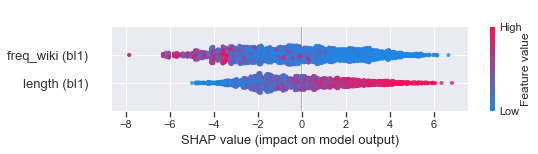

In [87]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_sumary_baseline1_bar.png', dpi=900)

### (2.1.1) Baseline II SHAP values

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_baseline_2[dataset_index].train)
train = train.loc[:, train.columns != 'log_freq_wiki (bl2)']
test = remove_labels_for_binary_df(datasets_fc_baseline_2[dataset_index].test)
test = test.loc[:, test.columns != 'log_freq_wiki (bl2)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

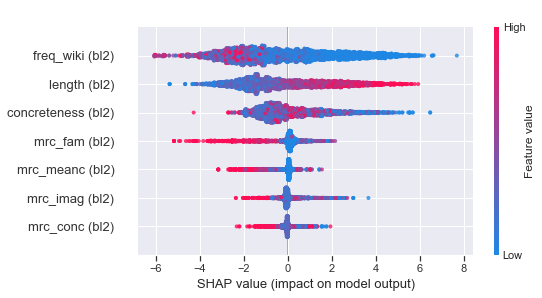

In [89]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_sumary_baseline2.png', dpi=900)

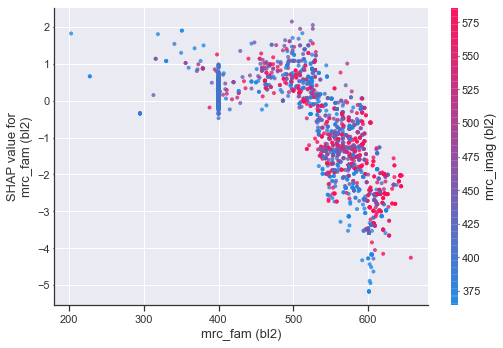

In [90]:
fig = shap.dependence_plot('mrc_fam (bl2)', shap_values, x_train, interaction_index=4, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_baseline2.png', dpi=900)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 4833 samples in 0.007s...
[t-SNE] Computed neighbors for 4833 samples in 0.272s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4833
[t-SNE] Computed conditional probabilities for sample 2000 / 4833
[t-SNE] Computed conditional probabilities for sample 3000 / 4833
[t-SNE] Computed conditional probabilities for sample 4000 / 4833
[t-SNE] Computed conditional probabilities for sample 4833 / 4833
[t-SNE] Mean sigma: 32.624113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.531189
[t-SNE] Error after 1000 iterations: 0.183531


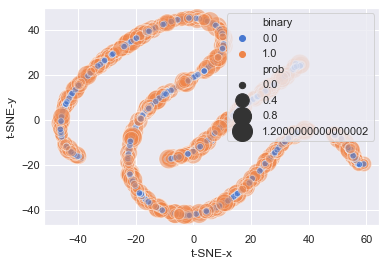

<Figure size 432x288 with 0 Axes>

In [91]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne2/t_sne_baseline2.pdf')

### (2.1.3) Linguistic SHAP values

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_linguistic[dataset_index].train)
train = train.loc[:, train.columns != 'dep_relation_to_head (lin)']
test = remove_labels_for_binary_df(datasets_fc_linguistic[dataset_index].test)
test = test.loc[:, test.columns != 'dep_relation_to_head (lin)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

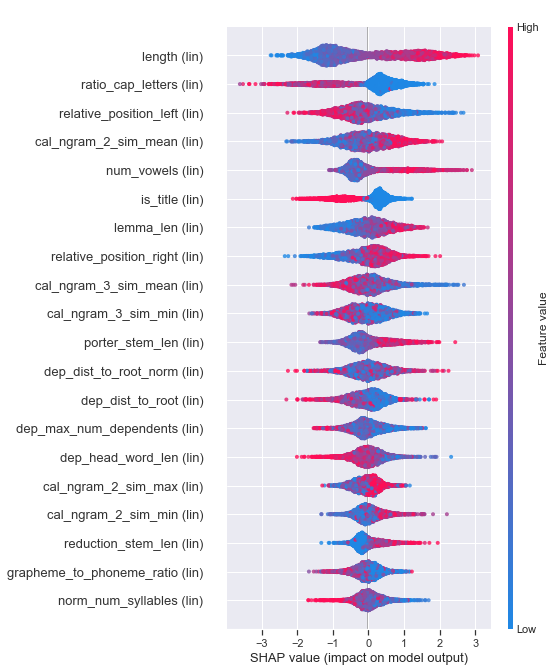

In [93]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_linguistic.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


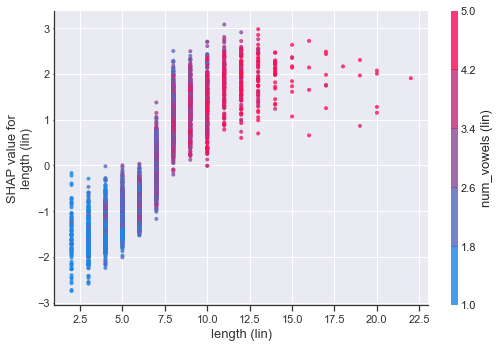

In [94]:
fig = shap.dependence_plot('length (lin)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_linguistic_length_vowels.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


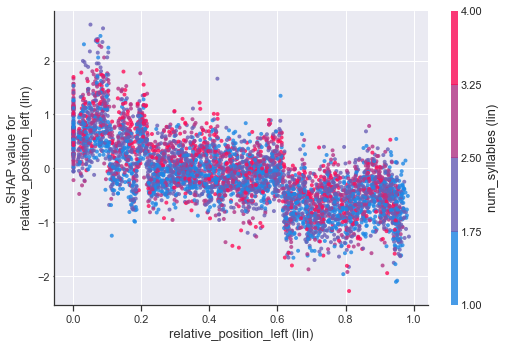

In [95]:
fig = shap.dependence_plot('relative_position_left (lin)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_linguistic_rel_pos.png', dpi=900)

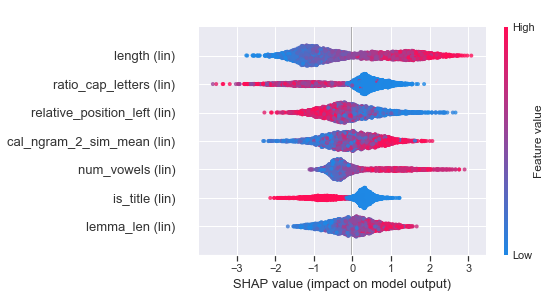

In [96]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, max_display=7, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_linguistic_small.png', dpi=900)

In [ ]:
cols = ['ratio_non_alpha (lin)', 'grapheme_to_phoneme_ratio (lin)','num_pronounciations (lin)','hyphenated (lin)', \
        'reduction_lemma_len (lin)', 'vowel_consonant_ratio (lin)', 'porter_stem_len (lin)', \
        'porter_stemmer_num_steps (lin)', 'binary']
train = remove_labels_for_binary_df(datasets_fc_linguistic[dataset_index].train)
train = train.loc[:, cols]
test = remove_labels_for_binary_df(datasets_fc_linguistic[dataset_index].test)
test = test.loc[:, cols]
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

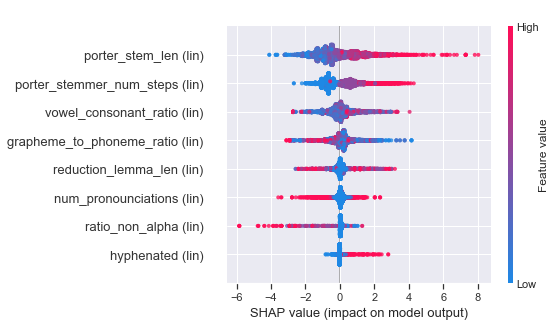

In [99]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_linguistic2.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


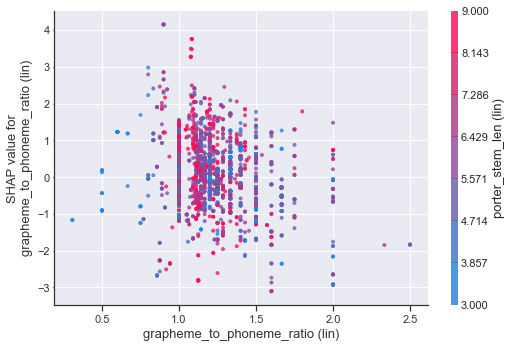

In [100]:
fig = shap.dependence_plot('grapheme_to_phoneme_ratio (lin)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_linguistic_graph.png', dpi=900)

### (2.1.4) Psycholingustic SHAP values

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_psycholinguistic[dataset_index].train)
test = remove_labels_for_binary_df(datasets_fc_psycholinguistic[dataset_index].test)
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

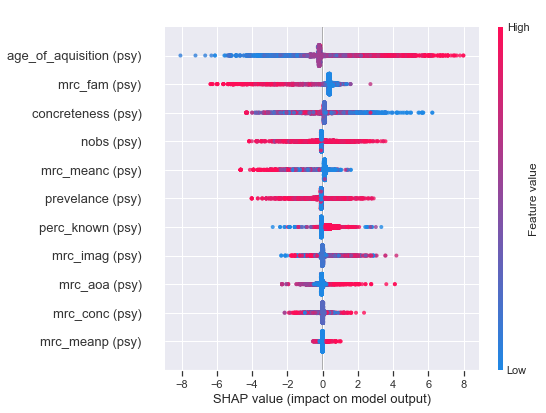

In [102]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_psycho.png', dpi=900)

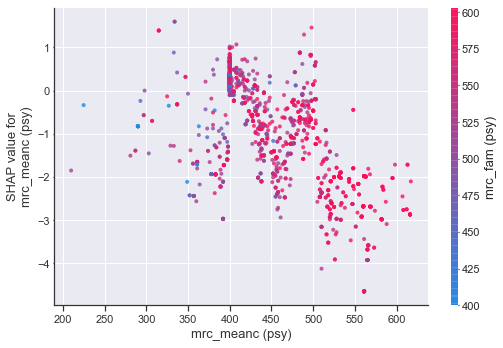

In [104]:
fig = shap.dependence_plot('mrc_meanc (psy)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_psycho.png', dpi=900)

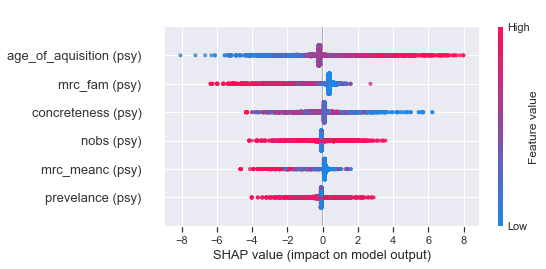

In [105]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=6)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_psycho_small.png', dpi=900)

### (2.1.5) Semantic SHAP values

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_semantic[dataset_index].train)
train = train.loc[:, train.columns != 'dbp_type_00 (sem)']
train = train.loc[:, train.columns != 'dbp_type_25 (sem)']
train = train.loc[:, train.columns != 'swn_avg_objective_score (sem)']
test = remove_labels_for_binary_df(datasets_fc_semantic[dataset_index].test)
test = test.loc[:, test.columns != 'dbp_type_00 (sem)']
test = test.loc[:, test.columns != 'dbp_type_25 (sem)']
test = test.loc[:, test.columns != 'swn_avg_objective_score (sem)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

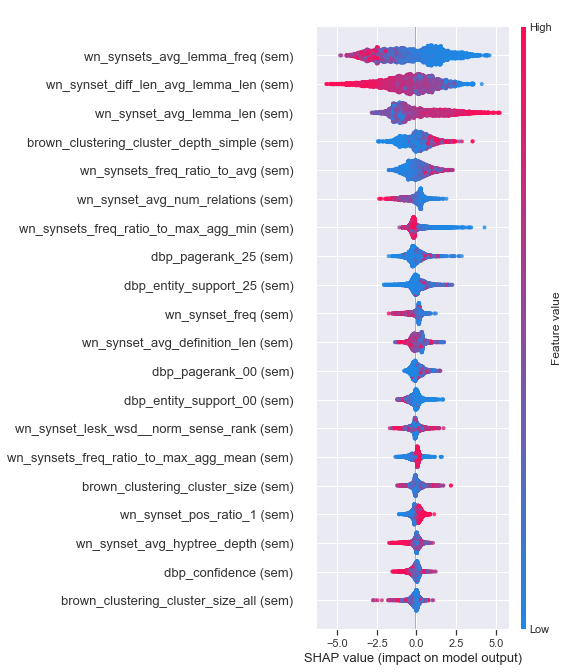

In [109]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_semantic.png', dpi=900)

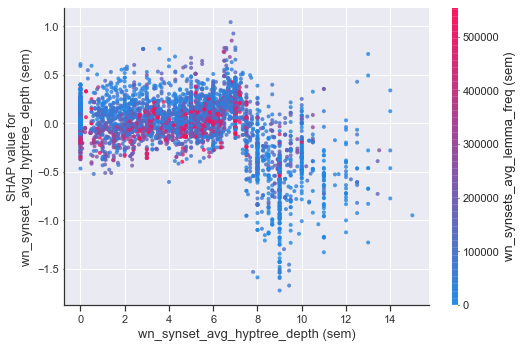

In [111]:
fig = shap.dependence_plot('wn_synset_avg_hyptree_depth (sem)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_semantic.png', dpi=900)

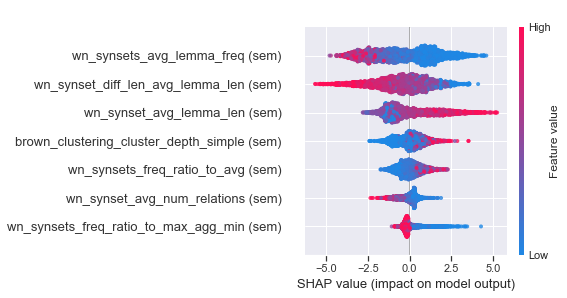

In [112]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=7)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_semantic_small.png', dpi=900)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4833 samples in 0.017s...
[t-SNE] Computed neighbors for 4833 samples in 0.644s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4833
[t-SNE] Computed conditional probabilities for sample 2000 / 4833
[t-SNE] Computed conditional probabilities for sample 3000 / 4833
[t-SNE] Computed conditional probabilities for sample 4000 / 4833
[t-SNE] Computed conditional probabilities for sample 4833 / 4833
[t-SNE] Mean sigma: 5.973670
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.598091
[t-SNE] Error after 1000 iterations: 0.406243


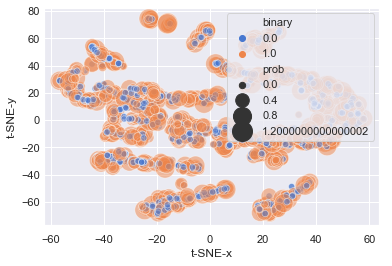

<Figure size 432x288 with 0 Axes>

In [114]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne2/t_sne_semantic.pdf')

### (2.1.6) Corpus SHAP values

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_corpus[dataset_index].train)
test = remove_labels_for_binary_df(datasets_fc_corpus[dataset_index].test)
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

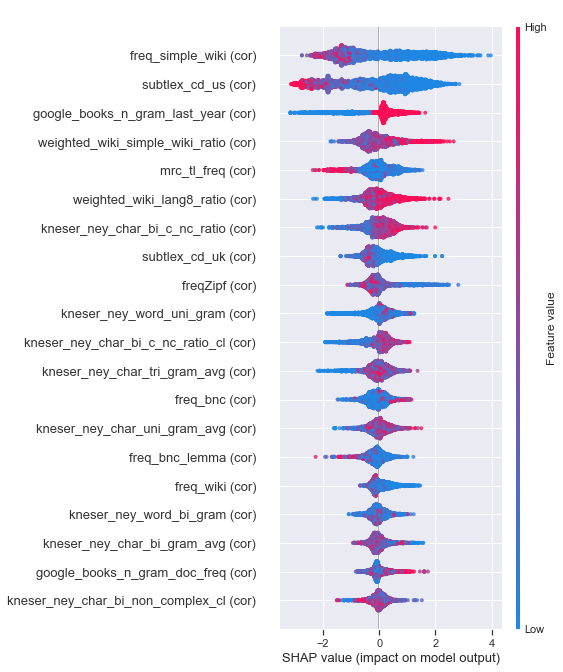

In [124]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_corpus.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


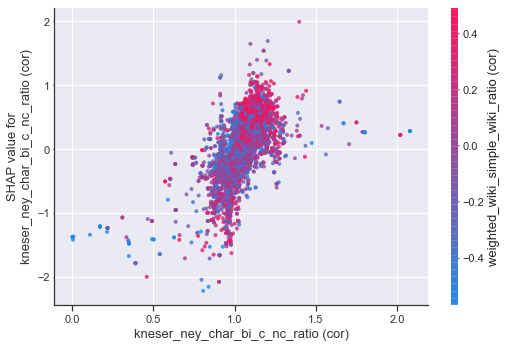

In [127]:
fig = shap.dependence_plot('kneser_ney_char_bi_c_nc_ratio (cor)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_corpus_kn_c_nc.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


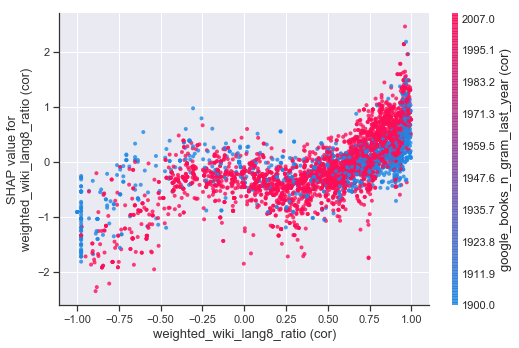

In [62]:
fig = shap.dependence_plot('weighted_wiki_lang8_ratio (cor)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_corpus_wiki_ratio.png', dpi=900)

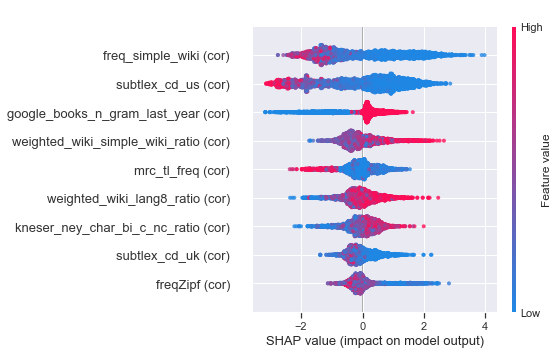

In [63]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=9)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_corpus_small.png', dpi=900)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4833 samples in 0.013s...
[t-SNE] Computed neighbors for 4833 samples in 0.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4833
[t-SNE] Computed conditional probabilities for sample 2000 / 4833
[t-SNE] Computed conditional probabilities for sample 3000 / 4833
[t-SNE] Computed conditional probabilities for sample 4000 / 4833
[t-SNE] Computed conditional probabilities for sample 4833 / 4833
[t-SNE] Mean sigma: 37.804939
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.594376
[t-SNE] Error after 1000 iterations: 0.317293


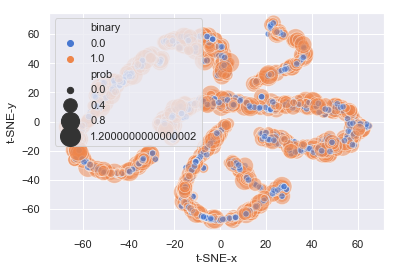

<Figure size 432x288 with 0 Axes>

In [64]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne2/t_sne_corpus.pdf')

### (2.1.7) Dictionary SHAP values

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_dictionary[dataset_index].train)
test = remove_labels_for_binary_df(datasets_fc_dictionary[dataset_index].test)
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

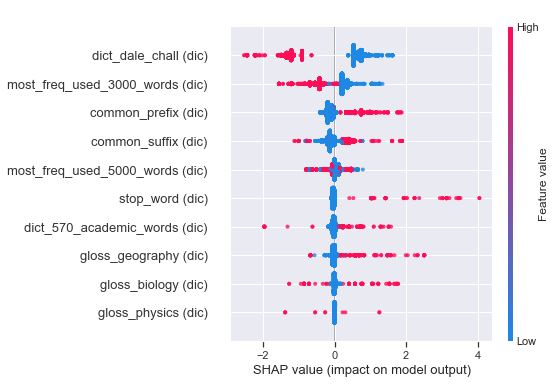

In [67]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_dictionary.png', dpi=900)

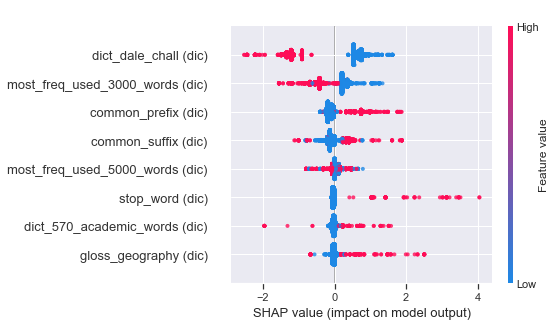

In [68]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=8)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_dictionary_small.png', dpi=900)

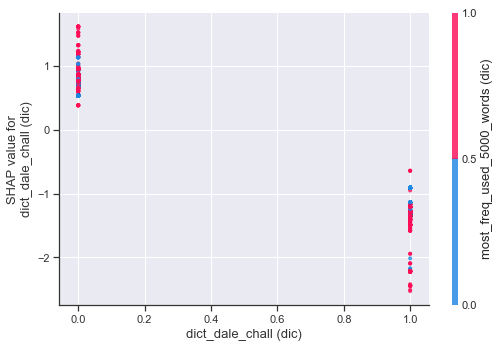

In [70]:
fig = shap.dependence_plot('dict_dale_chall (dic)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_dictionary.png', dpi=900)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4833 samples in 0.027s...
[t-SNE] Computed neighbors for 4833 samples in 0.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4833
[t-SNE] Computed conditional probabilities for sample 2000 / 4833
[t-SNE] Computed conditional probabilities for sample 3000 / 4833
[t-SNE] Computed conditional probabilities for sample 4000 / 4833
[t-SNE] Computed conditional probabilities for sample 4833 / 4833
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.960354
[t-SNE] Error after 1000 iterations: 0.271846


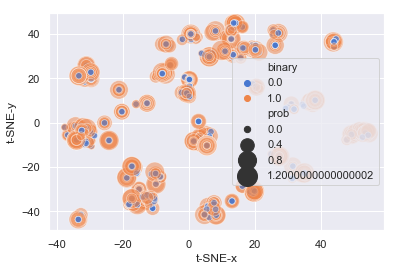

<Figure size 432x288 with 0 Axes>

In [71]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne2/t_sne_dictionary.pdf')

## (2.1.8) All Features SHAP values Wikipedia

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_all[0].train)
train = train.loc[:, train.columns != 'dbp_type_00 (sem)']
train = train.loc[:, train.columns != 'dbp_type_25 (sem)']
train = train.loc[:, train.columns != 'swn_avg_objective_score (sem)']
train = train.loc[:, train.columns != 'relative_position_centered (lin)']
train = train.loc[:, train.columns != 'relative_position_right (lin)']
train = train.loc[:, train.columns != 'dep_relation_to_head (lin)']
test = remove_labels_for_binary_df(datasets_fc_all[0].test)
test = test.loc[:, test.columns != 'dbp_type_00 (sem)']
test = test.loc[:, test.columns != 'dbp_type_25 (sem)']
test = test.loc[:, test.columns != 'swn_avg_objective_score (sem)']
test = test.loc[:, test.columns != 'relative_position_centered (lin)']
test = test.loc[:, test.columns != 'relative_position_right (lin)']
test = test.loc[:, test.columns != 'dep_relation_to_head (lin)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

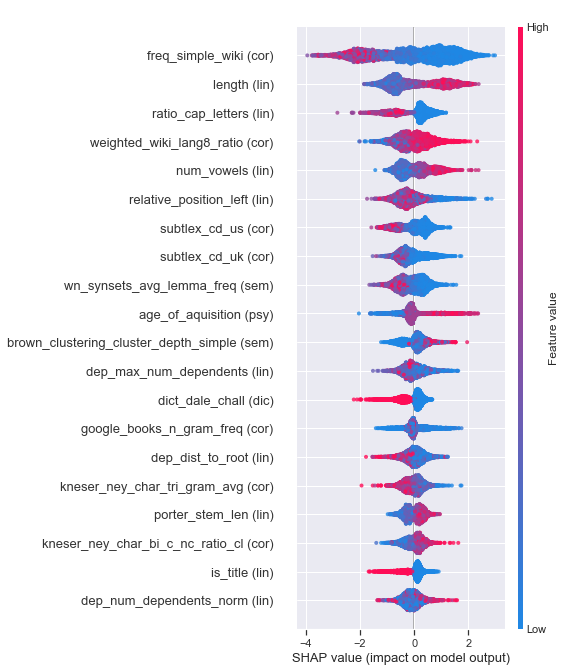

In [130]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_all_wikipedia.png', dpi=900)

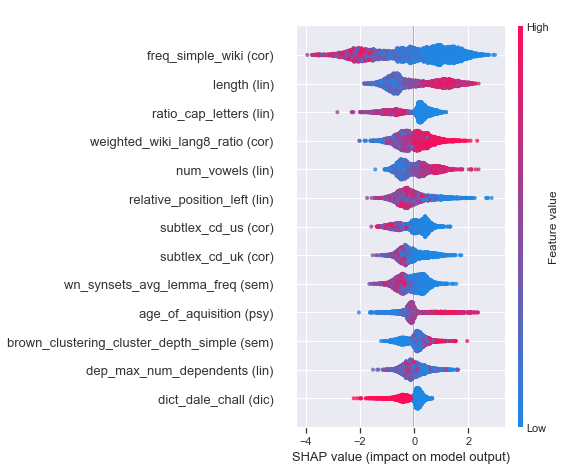

In [81]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=13)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_all_wikipedia_small_4.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


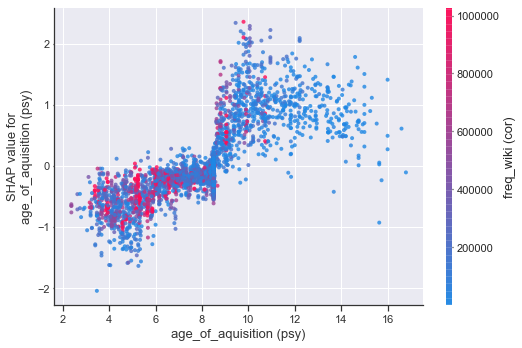

In [134]:
fig = shap.dependence_plot('age_of_aquisition (psy)', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_dependency_all_aoa.png', dpi=900)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5551 samples in 0.044s...
[t-SNE] Computed neighbors for 5551 samples in 1.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5551
[t-SNE] Computed conditional probabilities for sample 2000 / 5551
[t-SNE] Computed conditional probabilities for sample 3000 / 5551
[t-SNE] Computed conditional probabilities for sample 4000 / 5551
[t-SNE] Computed conditional probabilities for sample 5000 / 5551
[t-SNE] Computed conditional probabilities for sample 5551 / 5551
[t-SNE] Mean sigma: 45.524767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.157436
[t-SNE] Error after 1000 iterations: 0.438103


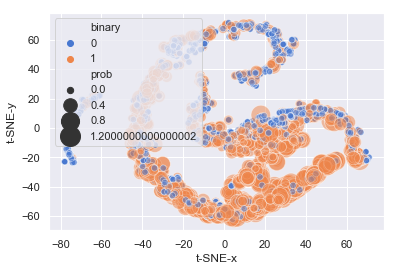

<Figure size 432x288 with 0 Axes>

In [110]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
#train['all_caps'] = train['all_caps'].apply(lambda val : int(val))
#train['is_title'] = train['is_title'].apply(lambda val : int(val))
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne/t_sne_all.pdf')

## (2.1.9) All Features SHAP values WikiNews

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_all[1].train)
train = train.loc[:, train.columns != 'dbp_type_00 (sem)']
train = train.loc[:, train.columns != 'dbp_type_25 (sem)']
train = train.loc[:, train.columns != 'swn_avg_objective_score (sem)']
train = train.loc[:, train.columns != 'relative_position_centered (lin)']
train = train.loc[:, train.columns != 'relative_position_right (lin)']
train = train.loc[:, train.columns != 'dep_relation_to_head (lin)']
test = remove_labels_for_binary_df(datasets_fc_all[1].test)
test = test.loc[:, test.columns != 'dbp_type_00 (sem)']
test = test.loc[:, test.columns != 'dbp_type_25 (sem)']
test = test.loc[:, test.columns != 'swn_avg_objective_score (sem)']
test = test.loc[:, test.columns != 'relative_position_centered (lin)']
test = test.loc[:, test.columns != 'relative_position_right (lin)']
test = test.loc[:, test.columns != 'dep_relation_to_head (lin)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

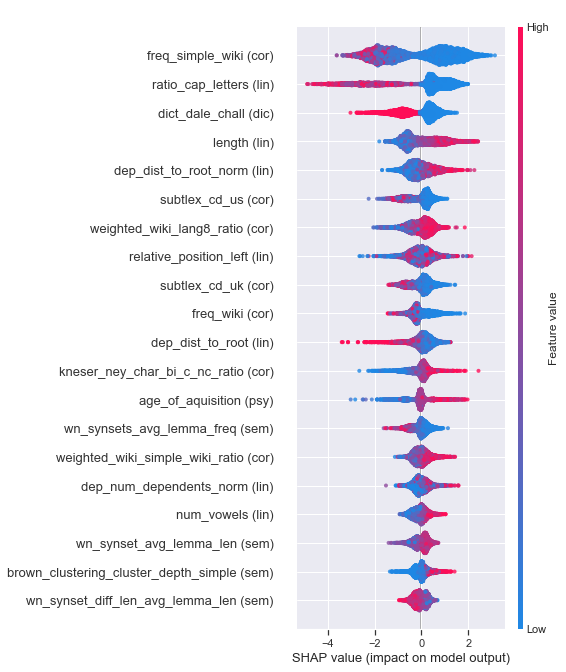

In [83]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_all_wikinews.png', dpi=900)

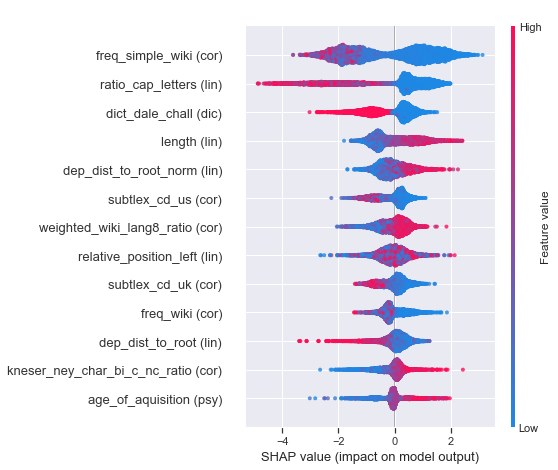

In [84]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=13)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_all_wikinews_small.png', dpi=900)

## (2.1.10) All Features SHAP values News

In [ ]:
train = remove_labels_for_binary_df(datasets_fc_all[2].train)
train = train.loc[:, train.columns != 'dbp_type_00 (sem)']
train = train.loc[:, train.columns != 'dbp_type_25 (sem)']
train = train.loc[:, train.columns != 'swn_avg_objective_score (sem)']
train = train.loc[:, train.columns != 'relative_position_centered (lin)']
train = train.loc[:, train.columns != 'relative_position_right (lin)']
train = train.loc[:, train.columns != 'dep_relation_to_head (lin)']
test = remove_labels_for_binary_df(datasets_fc_all[2].test)
test = test.loc[:, test.columns != 'dbp_type_00 (sem)']
test = test.loc[:, test.columns != 'dbp_type_25 (sem)']
test = test.loc[:, test.columns != 'swn_avg_objective_score (sem)']
test = test.loc[:, test.columns != 'relative_position_centered (lin)']
test = test.loc[:, test.columns != 'relative_position_right (lin)']
test = test.loc[:, test.columns != 'dep_relation_to_head (lin)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

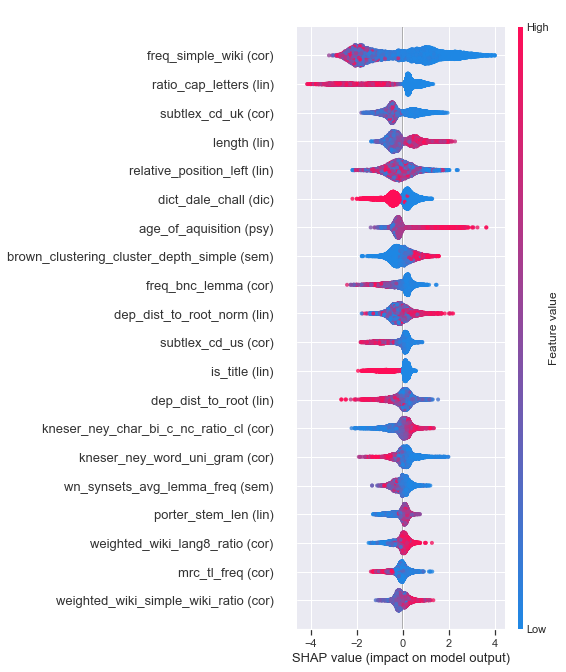

In [86]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_all_news.png', dpi=900)

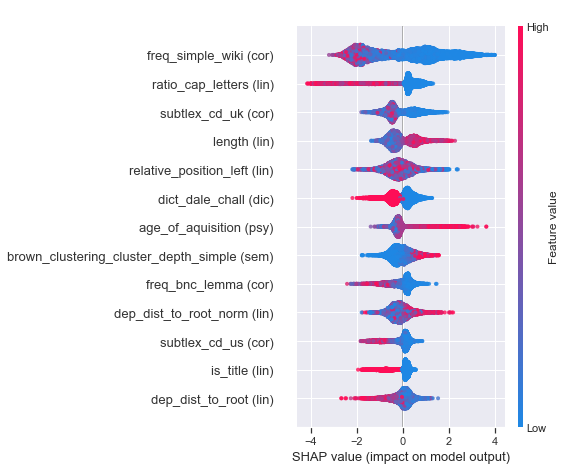

In [87]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=13)
plt.tight_layout()
plt.savefig('../plots/features/shap2/shap_summary_all_news_small.png', dpi=900)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 11944 samples in 0.145s...
[t-SNE] Computed neighbors for 11944 samples in 5.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11944
[t-SNE] Computed conditional probabilities for sample 2000 / 11944
[t-SNE] Computed conditional probabilities for sample 3000 / 11944
[t-SNE] Computed conditional probabilities for sample 4000 / 11944
[t-SNE] Computed conditional probabilities for sample 5000 / 11944
[t-SNE] Computed conditional probabilities for sample 6000 / 11944
[t-SNE] Computed conditional probabilities for sample 7000 / 11944
[t-SNE] Computed conditional probabilities for sample 8000 / 11944
[t-SNE] Computed conditional probabilities for sample 9000 / 11944
[t-SNE] Computed conditional probabilities for sample 10000 / 11944
[t-SNE] Computed conditional probabilities for sample 11000 / 11944
[t-SNE] Computed conditional probabilities for sample 11944 / 11944
[t-SNE] Mean sigma: 21.425723
[t-SNE] KL divergen

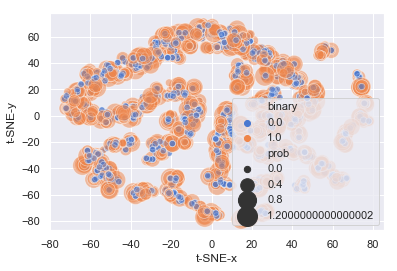

<Figure size 432x288 with 0 Axes>

In [89]:
tsne = TSNE(n_components=2, verbose=1, perplexity=70, n_iter=1000)
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne2/t_sne_all_news.pdf')

# 2.2 Scatter/Bar Plots

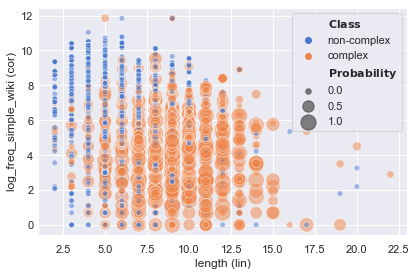

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

concat_features = concat_feature_datasets(datasets_fc_corpus, datasets_fc_linguistic)
sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

#Select wikipedia train set of concatenation
data = concat_features[0].train

ax1 = sns.scatterplot(x="length (lin)", y="log_freq_simple_wiki (cor)", hue="binary", size='prob',
            sizes=(30, 280), alpha=.5, palette="muted",
            data=data)
ax1.legend(loc='lower left', ncol=2)
handles, _ = ax1.get_legend_handles_labels()
handles[4].set_alpha(0.6)
handles[5].set_alpha(0.6)
handles[6].set_alpha(0.6)
ax1.legend(handles, ["$\\bf{Class}$", "non-complex", "complex", '$\\bf{Probability}$', '0.0', '0.5', '1.0'])
ax1.figure.set_size_inches(6, 4)
plt.tight_layout()
plt.show(ax1)

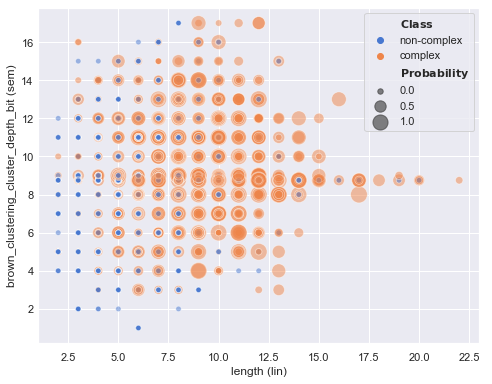

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

concat_features = concat_feature_datasets(datasets_fc_brown_clustering, datasets_fc_linguistic,
                                          datasets_fc_psycholinguistic)
sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

ax1 = sns.scatterplot(x="length (lin)", y="brown_clustering_cluster_depth_bit (sem)", hue="binary", size='prob',
            sizes=(30, 280), alpha=.5, palette="muted",
            data=data)
ax1.legend(loc='lower left', ncol=2)
handles, _ = ax1.get_legend_handles_labels()
handles[4].set_alpha(0.6)
handles[5].set_alpha(0.6)
handles[6].set_alpha(0.6)
ax1.legend(handles, ["$\\bf{Class}$", "non-complex", "complex", '$\\bf{Probability}$', '0.0', '0.5', '1.0'])
ax1.figure.set_size_inches(7, 5.5)
plt.tight_layout()
plt.show(ax1)

In [ ]:
figure = ax1.get_figure()
figure.savefig('../plots/features/brown-cluster-depth-length.png', dpi=900)

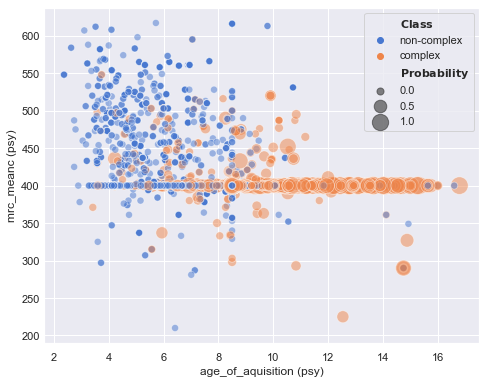

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

concat_features = concat_feature_datasets(datasets_fc_psycholinguistic, datasets_fc_linguistic)

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

data = concat_features[0].train

ax1 = sns.scatterplot(x="age_of_aquisition (psy)", y="mrc_meanc (psy)", hue="binary", size='prob',
            sizes=(50, 320), alpha=.5, palette="muted",
            data=data)

ax1.legend(loc='lower left', ncol=2)
handles, _ = ax1.get_legend_handles_labels()
handles[4].set_alpha(0.6)
handles[5].set_alpha(0.6)
handles[6].set_alpha(0.6)
ax1.legend(handles, ["$\\bf{Class}$", "non-complex", "complex", '$\\bf{Probability}$', '0.0', '0.5', '1.0'])
ax1.figure.set_size_inches(7, 5.5)
plt.tight_layout()
plt.show(ax1)

In [ ]:
figure = ax1.get_figure()
figure.savefig('../plots/features/meanc_aoa.png', dpi=900)

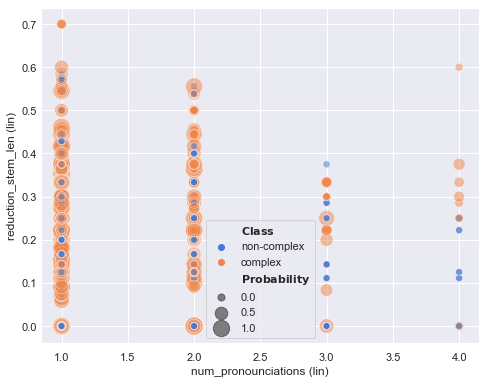

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

#Select wikipedia train set of concatenation
data = datasets_fc_linguistic[0].train

ax1 = sns.scatterplot(x="num_pronounciations (lin)", y="reduction_stem_len (lin)", hue="binary", size='prob',
            sizes=(50, 320), alpha=.5, palette="muted",
            data=data)

handles, _ = ax1.get_legend_handles_labels()
handles[4].set_alpha(0.6)
handles[5].set_alpha(0.6)
handles[6].set_alpha(0.6)
ax1.legend(handles, ["$\\bf{Class}$", "non-complex", "complex", '$\\bf{Probability}$', '0.0', '0.5', '1.0'])
ax1.figure.set_size_inches(7, 5.5)
plt.tight_layout()
plt.show(ax1)

In [ ]:
figure = ax1.get_figure()
figure.savefig('../plots/features/len-to-port-stem-steps.pdf')

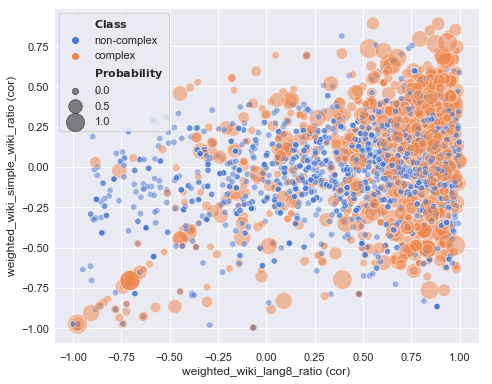

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

#Select wikipedia train set of concatenation
data = datasets_fc_corpus[0].train
data = data.loc[data['kneser_ney_char_bi_c_nc_ratio_cl (cor)']<1.2,]
ax1 = sns.scatterplot(x="weighted_wiki_lang8_ratio (cor)", y="weighted_wiki_simple_wiki_ratio (cor)", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
handles, _ = ax1.get_legend_handles_labels()
handles[4].set_alpha(0.6)
handles[5].set_alpha(0.6)
handles[6].set_alpha(0.6)
ax1.legend(handles, ["$\\bf{Class}$", "non-complex", "complex", '$\\bf{Probability}$', '0.0', '0.5', '1.0'])
ax1.figure.set_size_inches(7, 5.5)
plt.tight_layout()
plt.show(ax1)

In [ ]:
figure = ax1.get_figure()
figure.savefig('../plots/features/weighted-wiki-to-kn-bi-c-nc-cl.pdf')

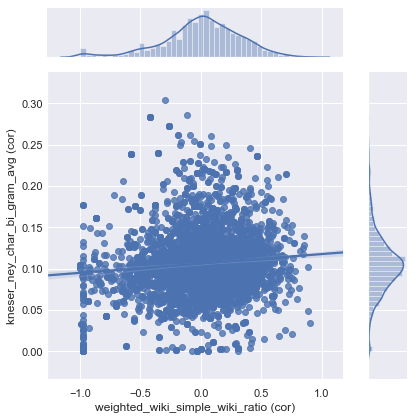

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

#Select wikipedia train set of concatenation
data = datasets_fc_corpus[0].train

ax1 = sns.jointplot(x="weighted_wiki_simple_wiki_ratio (cor)", y="kneser_ney_char_bi_gram_avg (cor)", data=data, kind="reg")
plt.tight_layout()
plt.show(ax1)

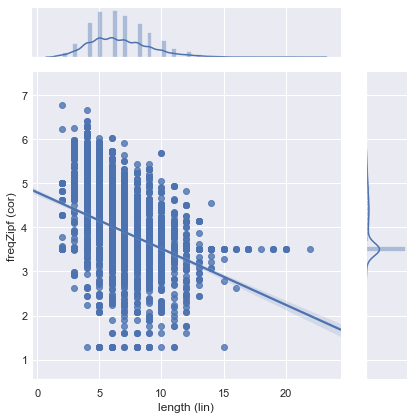

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

concat_features = concat_feature_datasets(datasets_fc_linguistic, datasets_fc_corpus)

#Select wikipedia train set of concatenation
data = concat_features[0].train

ax1 = sns.jointplot(x="length (lin)", y="freqZipf (cor)", data=data, kind="reg")
plt.tight_layout()
plt.show(ax1)

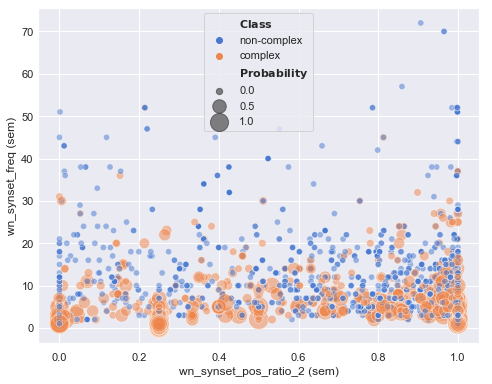

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

concat_features = concat_feature_datasets(datasets_fc_wordnet, datasets_fc_linguistic,
                                          datasets_fc_psycholinguistic)
sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

#Select wikipedia train set of concatenation
data = concat_features[0].train

ax1 = sns.scatterplot(x="wn_synset_pos_ratio_2 (sem)", y="wn_synset_freq (sem)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
handles, _ = ax1.get_legend_handles_labels()
handles[4].set_alpha(0.6)
handles[5].set_alpha(0.6)
handles[6].set_alpha(0.6)
ax1.legend(handles, ["$\\bf{Class}$", "non-complex", "complex", '$\\bf{Probability}$', '0.0', '0.5', '1.0'])
ax1.figure.set_size_inches(7, 5.5)
plt.tight_layout()
plt.show(ax1)

In [ ]:
figure = ax1.get_figure()
figure.savefig('../plots/features/syn-freq-to-avg-def-len.pdf')

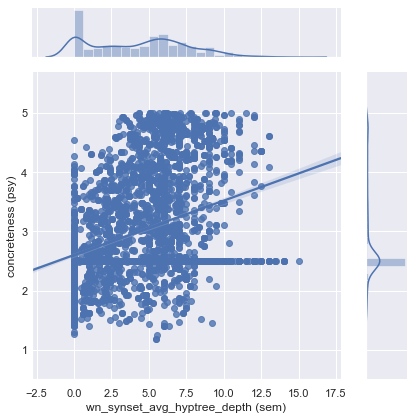

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

concat_features = concat_feature_datasets(datasets_fc_wordnet, datasets_fc_linguistic,
                                          datasets_fc_psycholinguistic)

#Select wikipedia train set of concatenation
data = concat_features[0].train

ax1 = sns.jointplot(x="wn_synset_avg_hyptree_depth (sem)", y="concreteness (psy)", data=data, kind="reg")
plt.tight_layout()
plt.show(ax1)

In [ ]:
ax1.savefig('../plots/features/wn-hyp-depth-to-conc.pdf')

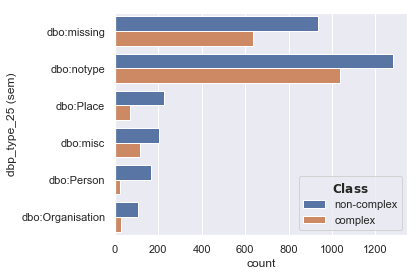

In [174]:
concat_features = concat_feature_datasets(datasets_fc_dbpedia, datasets_fc_linguistic,
                                          datasets_fc_psycholinguistic)
data = concat_features[0].train

ax1 = sns.countplot(y="dbp_type_25 (sem)", hue="binary", data=data)
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles, ["non-complex", "complex"], title='$\\bf{Class}$')
plt.tight_layout()
plt.show(model_plot)

In [175]:
figure = ax1.get_figure()
figure.savefig('../plots/features/dbp-rank-to-freq-types-bar.pdf')

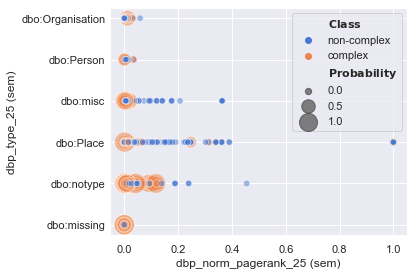

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

concat_features = concat_feature_datasets(datasets_fc_dbpedia, datasets_fc_linguistic,
                                          datasets_fc_psycholinguistic)
sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

ax1 = sns.scatterplot(x="dbp_norm_pagerank_25 (sem)", y="dbp_type_25 (sem)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
handles, _ = ax1.get_legend_handles_labels()
handles[4].set_alpha(0.6)
handles[5].set_alpha(0.6)
handles[6].set_alpha(0.6)
ax1.legend(handles, ["$\\bf{Class}$", "non-complex", "complex", '$\\bf{Probability}$', '0.0', '0.5', '1.0'])
plt.tight_layout()
plt.show(complexity_plot)

In [ ]:
figure = ax1.get_figure()
figure.savefig('../plots/features/dbp-rank-to-freq-types.pdf')

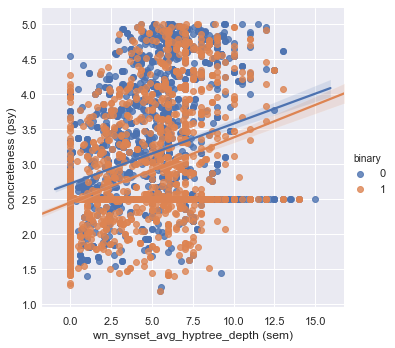

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

concat_features = concat_feature_datasets(datasets_fc_dbpedia, datasets_fc_linguistic,
                                          datasets_fc_psycholinguistic, datasets_fc_wordnet)
#Select wikipedia train set of concatenation
data = concat_features[0].train

ax1 = sns.lmplot(x="wn_synset_avg_hyptree_depth (sem)", y="concreteness (psy)", hue='binary', data=data)
plt.show(ax1)

In [ ]:
ax1.savefig('../plots/features/wn-hyp-depth-to-conc-2.pdf')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'legend.frameon':True, 'legend.scatterpoints': 1, 'ytick.major.size': 1,'ytick.minor.size': 1})

concat_features = concat_feature_datasets(datasets_fc_linguistic, datasets_fc_dictionary)

#Select wikipedia train set of concatenation
data = concat_features[2].train

ax1 = sns.catplot(x="dict_dale_chall (dic)", y="length (lin)", hue="binary", 
             alpha=.5, palette="muted", jitter=True,
             data=data)
ax1.legend()
ax1.figure.set_size_inches(7, 5.5)
plt.tight_layout()
plt.show(ax1)

In [201]:
ax1.savefig('../plots/features/len-to-dale-chall.png', dpi=900)

# 2.3 Feature Category Analysis

In [203]:
baseline_always_complex(datasets)

C:\Users\Studio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Studio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Studio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


dataset        f1      prec  rec              zc
0  Wikipedia  0.608496  0.437294  1.0  always_complex
1   WikiNews  0.531693  0.362113  1.0  always_complex
2       News  0.491968  0.326232  1.0  always_complex

In [209]:
baseline_vocab_clean(datasets)

dataset        f1      prec       rec           zc
0  Wikipedia  0.695527  0.563084  0.909434  vocab_clean
1   WikiNews  0.684280  0.544118  0.921708  vocab_clean
2       News  0.696108  0.549645  0.948980  vocab_clean

In [210]:
baseline_vocab_weighted(datasets)

dataset        f1      prec       rec              zc
0  Wikipedia  0.706587  0.585608  0.890566  vocab_weighted
1   WikiNews  0.708571  0.591885  0.882562  vocab_weighted
2       News  0.780261  0.717466  0.855102  vocab_weighted

In [211]:
baseline_vocab_conf(datasets)

dataset        f1      prec       rec          zc
0  Wikipedia  0.696456  0.588542  0.852830  vocab_conf
1   WikiNews  0.680851  0.594164  0.797153  vocab_conf
2       News  0.695745  0.726667  0.667347  vocab_conf

## X.x Feature Category Perfomance

In [382]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*mlp(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]
feature_eval_data = create_eval_df_from_results(results)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.296073  0.742424  0.184906                baseline_1
1    WikiNews  0.156863  0.368421  0.099644                baseline_1
2        News  0.196277  0.574257  0.118367                baseline_1
3   Wikipedia  0.295652  0.637500  0.192453                baseline_2
4    WikiNews  0.523013  0.634518  0.444840                baseline_2
5        News  0.461905  0.554286  0.395918                baseline_2
6   Wikipedia  0.658824  0.685714  0.633962                linguistic
7    WikiNews  0.626642  0.662698  0.594306                linguistic
8        News  0.586605  0.675532  0.518367                linguistic
9   Wikipedia  0.507109  0.681529  0.403774                 frequency
10   WikiNews  0.672504  0.662069  0.683274                 frequency
11       News  0.455090  0.853933  0.310204                 frequency
12  Wikipedia  0.413462  0.569536  0.324528            language_model
13   WikiNews  0.429752  0.512315  0.370107            language_model
14       News  0.395913  0.529010  0.316327            language_model
15  Wikipedia  0.576923  0.537459  0.622642                    corpus
16   WikiNews  0.512941  0.756944  0.387900                    corpus
17       News  0.115242  0.645833  0.063265                    corpus
18  Wikipedia  0.632111  0.475285  0.943396          psycholinguistic
19   WikiNews  0.489712  0.580488  0.423488          psycholinguistic
20       News  0.081871  0.913043  0.042857          psycholinguistic
21  Wikipedia  0.310976  0.809524  0.192453                   wordnet
22   WikiNews  0.177215  0.800000  0.099644                   wordnet
23       News  0.146341  0.906977  0.079592                   wordnet
24  Wikipedia  0.159236  0.510204  0.094340                   dbpedia
25   WikiNews  0.108626  0.531250  0.060498                   dbpedia
26       News  0.242331  0.487654  0.161224                   dbpedia
27  Wikipedia  0.221519  0.686275  0.132075                  semantic
28   WikiNews  0.521569  0.580786  0.473310                  semantic
29       News  0.531451  0.716263  0.422449                  semantic
30  Wikipedia  0.506977  0.660606  0.411321                dictionary
31   WikiNews  0.530702  0.691429  0.430605                dictionary
32       News  0.483607  0.731405  0.361224                dictionary
33  Wikipedia  0.628231  0.663866  0.596226           corpus+semantic
34   WikiNews  0.416040  0.703390  0.295374           corpus+semantic
35       News  0.723742  0.637636  0.836735           corpus+semantic
36  Wikipedia  0.471503  0.752066  0.343396  wordnet+psycholinguistic
37   WikiNews  0.610801  0.640625  0.583630  wordnet+psycholinguistic
38       News  0.581574  0.548913  0.618367  wordnet+psycholinguistic
39  Wikipedia  0.612855  0.507426  0.773585                       all
40   WikiNews  0.562232  0.402458  0.932384                       all
41       News  0.625899  0.758721  0.532653                       all

In [381]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec               zc
6   Wikipedia  0.658824  0.685714  0.633962       linguistic
10   WikiNews  0.672504  0.662069  0.683274        frequency
35       News  0.723742  0.637636  0.836735  corpus+semantic

In [ ]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*xgboost(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]

In [385]:
feature_eval_data = create_eval_df_from_results(results)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.669187  0.670455  0.667925                baseline_1
1    WikiNews  0.696270  0.695035  0.697509                baseline_1
2        News  0.770961  0.772541  0.769388                baseline_1
3   Wikipedia  0.675573  0.683398  0.667925                baseline_2
4    WikiNews  0.745167  0.736111  0.754448                baseline_2
5        News  0.784679  0.796218  0.773469                baseline_2
6   Wikipedia  0.648330  0.676230  0.622642                linguistic
7    WikiNews  0.680147  0.703422  0.658363                linguistic
8        News  0.735829  0.773034  0.702041                linguistic
9   Wikipedia  0.692737  0.683824  0.701887                 frequency
10   WikiNews  0.741135  0.738516  0.743772                 frequency
11       News  0.810700  0.817427  0.804082                 frequency
12  Wikipedia  0.674115  0.665441  0.683019            language_model
13   WikiNews  0.733447  0.701299  0.768683            language_model
14       News  0.777663  0.788260  0.767347            language_model
15  Wikipedia  0.706107  0.714286  0.698113                    corpus
16   WikiNews  0.758974  0.730263  0.790036                    corpus
17       News  0.812371  0.820833  0.804082                    corpus
18  Wikipedia  0.509524  0.690323  0.403774          psycholinguistic
19   WikiNews  0.558559  0.760736  0.441281          psycholinguistic
20       News  0.650814  0.841424  0.530612          psycholinguistic
21  Wikipedia  0.705882  0.709924  0.701887                   wordnet
22   WikiNews  0.749543  0.770677  0.729537                   wordnet
23       News  0.782427  0.802575  0.763265                   wordnet
24  Wikipedia  0.424508  0.505208  0.366038                   dbpedia
25   WikiNews  0.454545  0.541872  0.391459                   dbpedia
26       News  0.556242  0.705329  0.459184                   dbpedia
27  Wikipedia  0.711111  0.698182  0.724528                  semantic
28   WikiNews  0.745946  0.755474  0.736655                  semantic
29       News  0.791753  0.800000  0.783673                  semantic
30  Wikipedia  0.545455  0.661290  0.464151                dictionary
31   WikiNews  0.520000  0.692308  0.416370                dictionary
32       News  0.490411  0.745833  0.365306                dictionary
33  Wikipedia  0.736243  0.740458  0.732075           corpus+semantic
34   WikiNews  0.760563  0.752613  0.768683           corpus+semantic
35       News  0.806186  0.814583  0.797959           corpus+semantic
36  Wikipedia  0.736059  0.725275  0.747170  wordnet+psycholinguistic
37   WikiNews  0.775735  0.802281  0.750890  wordnet+psycholinguistic
38       News  0.781971  0.803879  0.761224  wordnet+psycholinguistic
39  Wikipedia  0.708571  0.715385  0.701887                       all
40   WikiNews  0.804921  0.795139  0.814947                       all
41       News  0.815416  0.810484  0.820408                       all

In [386]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec               zc
33  Wikipedia  0.736243  0.740458  0.732075  corpus+semantic
40   WikiNews  0.804921  0.795139  0.814947              all
41       News  0.815416  0.810484  0.820408              all

In [ ]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*random_forest(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]

In [397]:
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.667969  0.692308  0.645283                baseline_1
1    WikiNews  0.681564  0.714844  0.651246                baseline_1
2        News  0.735294  0.757576  0.714286                baseline_1
3   Wikipedia  0.697495  0.712598  0.683019                baseline_2
4    WikiNews  0.736462  0.747253  0.725979                baseline_2
5        News  0.703247  0.779156  0.640816                baseline_2
6   Wikipedia  0.681913  0.759259  0.618868                linguistic
7    WikiNews  0.679317  0.727642  0.637011                linguistic
8        News  0.706286  0.802597  0.630612                linguistic
9   Wikipedia  0.701754  0.725806  0.679245                 frequency
10   WikiNews  0.760213  0.758865  0.761566                 frequency
11       News  0.806876  0.799599  0.814286                 frequency
12  Wikipedia  0.669173  0.666667  0.671698            language_model
13   WikiNews  0.715254  0.682848  0.750890            language_model
14       News  0.774194  0.764940  0.783673            language_model
15  Wikipedia  0.702703  0.719368  0.686792                    corpus
16   WikiNews  0.768696  0.751701  0.786477                    corpus
17       News  0.822581  0.812749  0.832653                    corpus
18  Wikipedia  0.461140  0.735537  0.335849          psycholinguistic
19   WikiNews  0.583710  0.801242  0.459075          psycholinguistic
20       News  0.559140  0.818898  0.424490          psycholinguistic
21  Wikipedia  0.716141  0.704380  0.728302                   wordnet
22   WikiNews  0.770642  0.795455  0.747331                   wordnet
23       News  0.792059  0.811563  0.773469                   wordnet
24  Wikipedia  0.255435  0.456311  0.177358                   dbpedia
25   WikiNews  0.349754  0.568000  0.252669                   dbpedia
26       News  0.346749  0.717949  0.228571                   dbpedia
27  Wikipedia  0.489796  0.613636  0.407547          brown_clustering
28   WikiNews  0.584980  0.657778  0.526690          brown_clustering
29       News  0.709539  0.747178  0.675510          brown_clustering
30  Wikipedia  0.705660  0.705660  0.705660                  semantic
31   WikiNews  0.747698  0.774809  0.722420                  semantic
32       News  0.793456  0.795082  0.791837                  semantic
33  Wikipedia  0.497653  0.658385  0.400000                dictionary
34   WikiNews  0.528634  0.693642  0.427046                dictionary
35       News  0.487738  0.733607  0.365306                dictionary
36  Wikipedia  0.713472  0.717557  0.709434           corpus+semantic
37   WikiNews  0.778360  0.763699  0.793594           corpus+semantic
38       News  0.830151  0.817822  0.842857           corpus+semantic
39  Wikipedia  0.732824  0.741313  0.724528  wordnet+psycholinguistic
40   WikiNews  0.767273  0.784387  0.750890  wordnet+psycholinguistic
41       News  0.802534  0.831510  0.775510  wordnet+psycholinguistic
42  Wikipedia  0.724806  0.745020  0.705660                       all
43   WikiNews  0.795737  0.794326  0.797153                       all
44       News  0.829465  0.820359  0.838776                       all

In [398]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec                        zc
38       News  0.830151  0.817822  0.842857           corpus+semantic
39  Wikipedia  0.732824  0.741313  0.724528  wordnet+psycholinguistic
43   WikiNews  0.795737  0.794326  0.797153                       all

In [393]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*random_forest_extra(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]

In [394]:
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.663918  0.731818  0.607547                baseline_1
1    WikiNews  0.390374  0.784946  0.259786                baseline_1
2        News  0.510324  0.920213  0.353061                baseline_1
3   Wikipedia  0.698039  0.726531  0.671698                baseline_2
4    WikiNews  0.726930  0.772000  0.686833                baseline_2
5        News  0.727674  0.791367  0.673469                baseline_2
6   Wikipedia  0.685950  0.757991  0.626415                linguistic
7    WikiNews  0.685714  0.737705  0.640569                linguistic
8        News  0.741648  0.816176  0.679592                linguistic
9   Wikipedia  0.688976  0.720165  0.660377                 frequency
10   WikiNews  0.755963  0.780303  0.733096                 frequency
11       News  0.814123  0.828753  0.800000                 frequency
12  Wikipedia  0.670498  0.680934  0.660377            language_model
13   WikiNews  0.716578  0.717857  0.715302            language_model
14       News  0.783145  0.788820  0.777551            language_model
15  Wikipedia  0.704280  0.726908  0.683019                    corpus
16   WikiNews  0.774648  0.766551  0.782918                    corpus
17       News  0.815117  0.815951  0.814286                    corpus
18  Wikipedia  0.491484  0.691781  0.381132          psycholinguistic
19   WikiNews  0.577273  0.798742  0.451957          psycholinguistic
20       News  0.603133  0.836957  0.471429          psycholinguistic
21  Wikipedia  0.703214  0.704545  0.701887                   wordnet
22   WikiNews  0.736449  0.775591  0.701068                   wordnet
23       News  0.788260  0.810345  0.767347                   wordnet
24  Wikipedia  0.082474  0.461538  0.045283                   dbpedia
25   WikiNews  0.298103  0.625000  0.195730                   dbpedia
26       News  0.336026  0.806202  0.212245                   dbpedia
27  Wikipedia  0.518681  0.621053  0.445283          brown_clustering
28   WikiNews  0.592742  0.683721  0.523132          brown_clustering
29       News  0.737634  0.779545  0.700000          brown_clustering
30  Wikipedia  0.687259  0.703557  0.671698                  semantic
31   WikiNews  0.745247  0.800000  0.697509                  semantic
32       News  0.795031  0.806723  0.783673                  semantic
33  Wikipedia  0.543046  0.654255  0.464151                dictionary
34   WikiNews  0.531868  0.695402  0.430605                dictionary
35       News  0.487738  0.733607  0.365306                dictionary
36  Wikipedia  0.705882  0.709924  0.701887           corpus+semantic
37   WikiNews  0.774648  0.766551  0.782918           corpus+semantic
38       News  0.826804  0.835417  0.818367           corpus+semantic
39  Wikipedia  0.714844  0.740891  0.690566  wordnet+psycholinguistic
40   WikiNews  0.750000  0.788235  0.715302  wordnet+psycholinguistic
41       News  0.799582  0.818376  0.781633  wordnet+psycholinguistic
42  Wikipedia  0.746154  0.760784  0.732075                       all
43   WikiNews  0.800712  0.800712  0.800712                       all
44       News  0.832477  0.838509  0.826531                       all

In [395]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec   zc
42  Wikipedia  0.746154  0.760784  0.732075  all
43   WikiNews  0.800712  0.800712  0.800712  all
44       News  0.832477  0.838509  0.826531  all

In [400]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*naive_bayes(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.671271  0.529412  0.916981                baseline_1
1    WikiNews  0.590662  0.425000  0.967972                baseline_1
2        News  0.593730  0.432432  0.946939                baseline_1
3   Wikipedia  0.643068  0.527845  0.822642                baseline_2
4    WikiNews  0.622120  0.459966  0.960854                baseline_2
5        News  0.582278  0.432245  0.891837                baseline_2
6   Wikipedia  0.623942  0.459075  0.973585                linguistic
7    WikiNews  0.541339  0.374150  0.978648                linguistic
8        News  0.523043  0.359268  0.961224                linguistic
9   Wikipedia  0.674003  0.530303  0.924528                 frequency
10   WikiNews  0.635071  0.476021  0.953737                 frequency
11       News  0.600770  0.438202  0.955102                 frequency
12  Wikipedia  0.669492  0.534989  0.894340            language_model
13   WikiNews  0.617925  0.462081  0.932384            language_model
14       News  0.593056  0.449474  0.871429            language_model
15  Wikipedia  0.674003  0.530303  0.924528                    corpus
16   WikiNews  0.635071  0.476021  0.953737                    corpus
17       News  0.600770  0.438202  0.955102                    corpus
18  Wikipedia  0.626437  0.505800  0.822642          psycholinguistic
19   WikiNews  0.580231  0.453815  0.804270          psycholinguistic
20       News  0.552888  0.405328  0.869388          psycholinguistic
21  Wikipedia  0.658730  0.507128  0.939623                   wordnet
22   WikiNews  0.555891  0.387640  0.982206                   wordnet
23       News  0.556480  0.392617  0.955102                   wordnet
24  Wikipedia  0.631447  0.473585  0.947170                   dbpedia
25   WikiNews  0.554745  0.392330  0.946619                   dbpedia
26       News  0.532571  0.369841  0.951020                   dbpedia
27  Wikipedia  0.288235  0.653333  0.184906          brown_clustering
28   WikiNews  0.355438  0.697917  0.238434          brown_clustering
29       News  0.412292  0.553265  0.328571          brown_clustering
30  Wikipedia  0.645995  0.491159  0.943396                  semantic
31   WikiNews  0.559184  0.391989  0.975089                  semantic
32       News  0.547356  0.382616  0.961224                  semantic
33  Wikipedia  0.640394  0.566860  0.735849                dictionary
34   WikiNews  0.640364  0.558201  0.750890                dictionary
35       News  0.461347  0.592949  0.377551                dictionary
36  Wikipedia  0.687237  0.546875  0.924528           corpus+semantic
37   WikiNews  0.634434  0.474427  0.957295           corpus+semantic
38       News  0.609883  0.447519  0.957143           corpus+semantic
39  Wikipedia  0.637931  0.515081  0.837736  wordnet+psycholinguistic
40   WikiNews  0.585746  0.426256  0.935943  wordnet+psycholinguistic
41       News  0.585556  0.429799  0.918367  wordnet+psycholinguistic
42  Wikipedia  0.687237  0.546875  0.924528                       all
43   WikiNews  0.634434  0.474427  0.957295                       all
44       News  0.609883  0.447519  0.957143                       all

In [401]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec               zc
34   WikiNews  0.640364  0.558201  0.750890       dictionary
36  Wikipedia  0.687237  0.546875  0.924528  corpus+semantic
38       News  0.609883  0.447519  0.957143  corpus+semantic
42  Wikipedia  0.687237  0.546875  0.924528              all
44       News  0.609883  0.447519  0.957143              all

In [ ]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*logistic_regression(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]

In [404]:
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.036765  0.714286  0.018868                baseline_1
1    WikiNews  0.033898  0.357143  0.017794                baseline_1
2        News  0.012048  0.375000  0.006122                baseline_1
3   Wikipedia  0.674033  0.658273  0.690566                baseline_2
4    WikiNews  0.582231  0.620968  0.548043                baseline_2
5        News  0.035785  0.692308  0.018367                baseline_2
6   Wikipedia  0.654397  0.714286  0.603774                linguistic
7    WikiNews  0.616279  0.676596  0.565836                linguistic
8        News  0.560284  0.665730  0.483673                linguistic
9   Wikipedia  0.687609  0.639610  0.743396                 frequency
10   WikiNews  0.629032  0.575221  0.693950                 frequency
11       News  0.566176  0.708589  0.471429                 frequency
12  Wikipedia  0.212389  0.486486  0.135849            language_model
13   WikiNews  0.233831  0.388430  0.167260            language_model
14       News  0.157377  0.400000  0.097959            language_model
15  Wikipedia  0.688468  0.632911  0.754717                    corpus
16   WikiNews  0.629032  0.575221  0.693950                    corpus
17       News  0.570037  0.706949  0.477551                    corpus
18  Wikipedia  0.504762  0.683871  0.400000          psycholinguistic
19   WikiNews  0.480769  0.740741  0.355872          psycholinguistic
20       News  0.436850  0.803279  0.300000          psycholinguistic
21  Wikipedia  0.242424  0.615385  0.150943                   wordnet
22   WikiNews  0.123324  0.250000  0.081851                   wordnet
23       News  0.561441  0.583700  0.540816                   wordnet
24  Wikipedia  0.000000  0.000000  0.000000                   dbpedia
25   WikiNews  0.000000  0.000000  0.000000                   dbpedia
26       News  0.000000  0.000000  0.000000                   dbpedia
27  Wikipedia  0.110345  0.640000  0.060377          brown_clustering
28   WikiNews  0.387991  0.552632  0.298932          brown_clustering
29       News  0.189142  0.666667  0.110204          brown_clustering
30  Wikipedia  0.488998  0.694444  0.377358                  semantic
31   WikiNews  0.471963  0.687075  0.359431                  semantic
32       News  0.375000  0.616822  0.269388                  semantic
33  Wikipedia  0.498845  0.642857  0.407547                dictionary
34   WikiNews  0.531868  0.695402  0.430605                dictionary
35       News  0.487936  0.710938  0.371429                dictionary
36  Wikipedia  0.684492  0.648649  0.724528           corpus+semantic
37   WikiNews  0.623574  0.669388  0.583630           corpus+semantic
38       News  0.645161  0.740741  0.571429           corpus+semantic
39  Wikipedia  0.459259  0.664286  0.350943  wordnet+psycholinguistic
40   WikiNews  0.464789  0.682759  0.352313  wordnet+psycholinguistic
41       News  0.489796  0.653061  0.391837  wordnet+psycholinguistic
42  Wikipedia  0.669131  0.655797  0.683019                       all
43   WikiNews  0.663102  0.664286  0.661922                       all
44       News  0.631944  0.729947  0.557143                       all

In [405]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec               zc
15  Wikipedia  0.688468  0.632911  0.754717           corpus
38       News  0.645161  0.740741  0.571429  corpus+semantic
43   WikiNews  0.663102  0.664286  0.661922              all

In [408]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*decision_tree(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.639847  0.649805  0.630189                baseline_1
1    WikiNews  0.678636  0.684783  0.672598                baseline_1
2        News  0.754995  0.778742  0.732653                baseline_1
3   Wikipedia  0.633776  0.637405  0.630189                baseline_2
4    WikiNews  0.723022  0.730909  0.715302                baseline_2
5        News  0.769883  0.801325  0.740816                baseline_2
6   Wikipedia  0.580524  0.576208  0.584906                linguistic
7    WikiNews  0.599641  0.605072  0.594306                linguistic
8        News  0.699069  0.708595  0.689796                linguistic
9   Wikipedia  0.651252  0.665354  0.637736                 frequency
10   WikiNews  0.743169  0.761194  0.725979                 frequency
11       News  0.787751  0.816193  0.761224                 frequency
12  Wikipedia  0.620424  0.633858  0.607547            language_model
13   WikiNews  0.696270  0.695035  0.697509            language_model
14       News  0.759279  0.790287  0.730612            language_model
15  Wikipedia  0.660079  0.692946  0.630189                    corpus
16   WikiNews  0.711504  0.707746  0.715302                    corpus
17       News  0.782791  0.805616  0.761224                    corpus
18  Wikipedia  0.490476  0.664516  0.388679          psycholinguistic
19   WikiNews  0.561798  0.762195  0.444840          psycholinguistic
20       News  0.614013  0.816949  0.491837          psycholinguistic
21  Wikipedia  0.686679  0.682836  0.690566                   wordnet
22   WikiNews  0.698292  0.747967  0.654804                   wordnet
23       News  0.765957  0.800000  0.734694                   wordnet
24  Wikipedia  0.404124  0.445455  0.369811                   dbpedia
25   WikiNews  0.468880  0.562189  0.402135                   dbpedia
26       News  0.550761  0.728188  0.442857                   dbpedia
27  Wikipedia  0.539130  0.635897  0.467925          brown_clustering
28   WikiNews  0.627451  0.698690  0.569395          brown_clustering
29       News  0.752371  0.777778  0.728571          brown_clustering
30  Wikipedia  0.664247  0.639860  0.690566                  semantic
31   WikiNews  0.695652  0.708487  0.683274                  semantic
32       News  0.767932  0.794760  0.742857                  semantic
33  Wikipedia  0.546667  0.664865  0.464151                dictionary
34   WikiNews  0.525386  0.691860  0.423488                dictionary
35       News  0.487603  0.750000  0.361224                dictionary
36  Wikipedia  0.674330  0.684825  0.664151           corpus+semantic
37   WikiNews  0.720562  0.711806  0.729537           corpus+semantic
38       News  0.782427  0.802575  0.763265           corpus+semantic
39  Wikipedia  0.682081  0.696850  0.667925  wordnet+psycholinguistic
40   WikiNews  0.746269  0.784314  0.711744  wordnet+psycholinguistic
41       News  0.764897  0.815242  0.720408  wordnet+psycholinguistic
42  Wikipedia  0.642586  0.647510  0.637736                       all
43   WikiNews  0.738095  0.706840  0.772242                       all
44       News  0.773469  0.773469  0.773469                       all

In [409]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec                        zc
11       News  0.787751  0.816193  0.761224                 frequency
21  Wikipedia  0.686679  0.682836  0.690566                   wordnet
40   WikiNews  0.746269  0.784314  0.711744  wordnet+psycholinguistic

In [410]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*knn(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.586873  0.600791  0.573585                baseline_1
1    WikiNews  0.608229  0.611511  0.604982                baseline_1
2        News  0.695833  0.710638  0.681633                baseline_1
3   Wikipedia  0.596958  0.601533  0.592453                baseline_2
4    WikiNews  0.621291  0.609589  0.633452                baseline_2
5        News  0.687435  0.699789  0.675510                baseline_2
6   Wikipedia  0.601594  0.637131  0.569811                linguistic
7    WikiNews  0.568702  0.613169  0.530249                linguistic
8        News  0.558456  0.629156  0.502041                linguistic
9   Wikipedia  0.649505  0.683333  0.618868                 frequency
10   WikiNews  0.698355  0.718045  0.679715                 frequency
11       News  0.745833  0.761702  0.730612                 frequency
12  Wikipedia  0.551859  0.573171  0.532075            language_model
13   WikiNews  0.608541  0.608541  0.608541            language_model
14       News  0.710338  0.712526  0.708163            language_model
15  Wikipedia  0.654832  0.685950  0.626415                    corpus
16   WikiNews  0.701818  0.717472  0.686833                    corpus
17       News  0.748441  0.762712  0.734694                    corpus
18  Wikipedia  0.643077  0.542857  0.788679          psycholinguistic
19   WikiNews  0.604972  0.494357  0.779359          psycholinguistic
20       News  0.602810  0.805461  0.481633          psycholinguistic
21  Wikipedia  0.585937  0.607287  0.566038                   wordnet
22   WikiNews  0.617916  0.635338  0.601423                   wordnet
23       News  0.737824  0.749474  0.726531                   wordnet
24  Wikipedia  0.386667  0.470270  0.328302                   dbpedia
25   WikiNews  0.397291  0.543210  0.313167                   dbpedia
26       News  0.543168  0.460882  0.661224                   dbpedia
27  Wikipedia  0.617021  0.581940  0.656604          brown_clustering
28   WikiNews  0.617476  0.679487  0.565836          brown_clustering
29       News  0.721030  0.760181  0.685714          brown_clustering
30  Wikipedia  0.637965  0.662602  0.615094                  semantic
31   WikiNews  0.694097  0.697842  0.690391                  semantic
32       News  0.734310  0.753219  0.716327                  semantic
33  Wikipedia  0.694079  0.615160  0.796226                dictionary
34   WikiNews  0.513636  0.710692  0.402135                dictionary
35       News  0.433382  0.766839  0.302041                dictionary
36  Wikipedia  0.658869  0.681452  0.637736           corpus+semantic
37   WikiNews  0.671454  0.677536  0.665480           corpus+semantic
38       News  0.758403  0.781385  0.736735           corpus+semantic
39  Wikipedia  0.582857  0.588462  0.577358  wordnet+psycholinguistic
40   WikiNews  0.631016  0.632143  0.629893  wordnet+psycholinguistic
41       News  0.733740  0.730769  0.736735  wordnet+psycholinguistic
42  Wikipedia  0.662768  0.685484  0.641509                       all
43   WikiNews  0.683544  0.694853  0.672598                       all
44       News  0.767296  0.788793  0.746939                       all

In [411]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec          zc
16   WikiNews  0.701818  0.717472  0.686833      corpus
33  Wikipedia  0.694079  0.615160  0.796226  dictionary
44       News  0.767296  0.788793  0.746939         all

In [ ]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*svm(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]

In [415]:
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

dataset        f1      prec       rec                        zc
0   Wikipedia  0.417755  0.677966  0.301887                baseline_1
1    WikiNews  0.554324  0.735294  0.444840                baseline_1
2        News  0.699301  0.815217  0.612245                baseline_1
3   Wikipedia  0.467980  0.673759  0.358491                baseline_2
4    WikiNews  0.549451  0.718391  0.444840                baseline_2
5        News  0.701714  0.797403  0.626531                baseline_2
6   Wikipedia  0.633540  0.701835  0.577358                linguistic
7    WikiNews  0.600390  0.663793  0.548043                linguistic
8        News  0.615029  0.709333  0.542857                linguistic
9   Wikipedia  0.377049  0.683168  0.260377                 frequency
10   WikiNews  0.495283  0.734266  0.373665                 frequency
11       News  0.677804  0.816092  0.579592                 frequency
12  Wikipedia  0.000000  0.000000  0.000000            language_model
13   WikiNews  0.000000  0.000000  0.000000            language_model
14       News  0.000000  0.000000  0.000000            language_model
15  Wikipedia  0.376022  0.676471  0.260377                    corpus
16   WikiNews  0.495283  0.734266  0.373665                    corpus
17       News  0.677804  0.816092  0.579592                    corpus
18  Wikipedia  0.433673  0.669291  0.320755          psycholinguistic
19   WikiNews  0.495192  0.762963  0.366548          psycholinguistic
20       News  0.577373  0.795699  0.453061          psycholinguistic
21  Wikipedia  0.460759  0.700000  0.343396                   wordnet
22   WikiNews  0.724960  0.655172  0.811388                   wordnet
23       News  0.780392  0.750943  0.812245                   wordnet
24  Wikipedia  0.316667  0.600000  0.215094                   dbpedia
25   WikiNews  0.397196  0.578231  0.302491                   dbpedia
26       News  0.510638  0.732824  0.391837                   dbpedia
27  Wikipedia  0.418953  0.617647  0.316981          brown_clustering
28   WikiNews  0.537585  0.746835  0.419929          brown_clustering
29       News  0.736018  0.814356  0.671429          brown_clustering
30  Wikipedia  0.317919  0.679012  0.207547                  semantic
31   WikiNews  0.421320  0.734513  0.295374                  semantic
32       News  0.648582  0.819315  0.536735                  semantic
33  Wikipedia  0.538976  0.657609  0.456604                dictionary
34   WikiNews  0.540305  0.696629  0.441281                dictionary
35       News  0.450425  0.736111  0.324490                dictionary
36  Wikipedia  0.301775  0.698630  0.192453           corpus+semantic
37   WikiNews  0.414322  0.736364  0.288256           corpus+semantic
38       News  0.645963  0.825397  0.530612           corpus+semantic
39  Wikipedia  0.436842  0.721739  0.313208  wordnet+psycholinguistic
40   WikiNews  0.512941  0.756944  0.387900  wordnet+psycholinguistic
41       News  0.781765  0.744917  0.822449  wordnet+psycholinguistic
42  Wikipedia  0.256098  0.666667  0.158491                       all
43   WikiNews  0.385417  0.718447  0.263345                       all
44       News  0.599746  0.794613  0.481633                       all

In [416]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

dataset        f1      prec       rec                        zc
6   Wikipedia  0.633540  0.701835  0.577358                linguistic
22   WikiNews  0.724960  0.655172  0.811388                   wordnet
41       News  0.781765  0.744917  0.822449  wordnet+psycholinguistic

In [ ]:
results = [Result(fs, fs.fc, fs.agg,
        precision_recall_fscore_support(*adaboost(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))))) for fs in all_fc_datasets]

In [ ]:
feature_eval_data = create_eval_df_from_results(results, True)
feature_eval_data

In [ ]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]